In [1]:
from sklearn.metrics import r2_score, mean_squared_error

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima

from sklearn.model_selection import train_test_split

import pandas as pd
import pandas_datareader.data as pdr

import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

from datetime import datetime
import yfinance as yf

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

# 시계열분석
- 시간의 흐름에 따라 기록된 데이터를 바탕으로 미래의 변화에 대한 추세를 분석하는 방법
- 시계열 분해 : 추세(Trend), 계절성(Seasonality), 잔차(Residual)로 분해하는 기법이며, 시간의 요인은 추세/계절성이며 외부요인은 잔차(불규칙요인)
- 모형 판단 : 주기적 반복/계절성이 있는지에 따라 Additive와 Multiplicative모형 중 어떤 모형이 더 적합할지 판단, 추세와 계절성이 별도로 존재하면 Additive 모형을, 추세에 따라 계절성이 있다면 Multiplicative 모형 적용

# 정상 시계열
- 평균과 분산이 일정하다

# 비정상 시계열
- 1. Trend : 데이터의 장기적인 증가또는 감소
- 2. Seasonality : 계절적 요인
- 3. Irregularity
- 4. Cyclic : 주기성

- Time Series = Trend + Seasonlity + Residual


## ARIMA
- ARIMA는 AR(Auto-Regressive)모형과 MA(Moving Average)모형을 합한 모형
- 비정상적 시계열 자료에 대해 분석하는 모형으로 차분을 사용하여 비정상 시계열을 정상 시계열로 만든다. 그리고 정상 시계열의 경우 AR모형과 MA모형이 상호 변환 가능하기에 두 모형을 결합하여 과거의 시점의 데이터로 현재 혹은 미래의 시점의 데이터를 예측하는 모형
- 파라미터는 (p, d, q)를 사용하며, p는 ACF로, d는 차분의 횟수, q는 PACF로 최적화 할 수 있다

**장단점**
- 시계열 자료 외에 다른 자료가 없을 때, 그 변동 상태를 확인할 수 있다
- 어떤 시계열에도 사용 가능


**정상성**
- 평균, 분산이 시간에 따라 일정한 성질을 가지고 있다는 것. 즉, 시계열 데이터의 특성이 시간의 흐름에 따라 변하지 않는 상태를 의미
- 추세나 계절성이 있는 시계열은 정상 시계열이 아니며, 비정상 시계열의 경우 ARIMA 모형을 적용시킬 수 없으므로 정상 시계열로 변환해야한다
- 공분산은 단지 시차에만 의존하고 시점 자체에는 의존하지 않는다
- 변환 방법은 로그 변환과 차분이 있다
1. 로그 변환 : 분산이 일정하지 않은 경우에 사용
2. 차분 : 로그변환 후 추세, 계절성이 존재하는 경우 추세와 계절성을 없애기 위해 차분 사용

**ADF TEST**
- 정상성 검정을 위해서는 Augmented Dicked-Fuller Test가 필요
- 귀무가설 : 정상성을 갖지 않는다
- 대립가설 : 정상성을 갖는다

### ACF (Auto Correlation Function)
- 자기상관 함수로 시차에 따른 자기상관성을 의미하며, ACF값을 시차에 따른 그래프로 시각화 해보면 최적의 p값을 찾을 수 있다
- 비정상 시계열의 경우 느리게 0에 접근하며 양수의 값을 가질 수도 있으며, 정상 시계열일 경우에는 ACF값이 빠르게 0으로 수렴. 0으로 수렴할 때 시차를 p값으로 설정

### PACF (Patial Auto Correlation Function)
- 편자기상관 함수로, ACF와는 다르게 시차가 다른 두 시계열 데이터 간의 순수한 상호 연관성을 나타낸다
- PACF값이 0에 수렴할 때 q값을 MA 모형의 q값으로 설정

> ACF는 과거 t시점까지의 데이터로 현재시점과의 상관성이라면, PACF는 과거 t시점의 데이터와 현재 시점의 데이터와의 상관성. 즉, ACF가 3차까지 라고 한다면, t와 t-3의 상관관계에서 t-1, t-2가 포함되어 있다. 해당 관계(t-1, t-2)를 뺀 것이 PACF이다

## AR(Auto regressive)
- 과거가 미래를 예측한다는 직관적인 사실에 의존
- 자기회귀과정이란 뜻으로, 현 시점의 데이터를 이전의 데이터들의 상관성으로 나타내는 모형으로 과거의 값이 현재의 값에 얼마나 영향을 미쳤는지 파악
- 최적의 성능을 가지는 모델을 만들 수 있는 과거의 값을 찾는데, 이값을 p라고 하며 AR(p) 모형이다
- $y_t = \theta_0 + \theta_1y_{t-1} + + \theta_2y_{t-2} + + \theta_py_{t-p} + \epsilon_t$
- (몇 시점 이전의 데이터를 포함)

## MA(Moving Average)
- 과거의 예측 오차들의 가중이동평균으로 현재 시점의 데이터를 표현하며 과거의 예측 오차를 이용하여 미래를 예측하는 모형이라고 할 수 있다
- 과거의 예측 오차들에 따라 가중이동평균이 달라지며, MA 모형은 최적의 모형이 되는 구간을 구하는 것이 중요. 해당 값이 MA(q)로 설정
- $y_t = \theta_0 + \epsilon_t + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + + \theta_q\epsilon_{t-q} $




## SARIMA
- 계절성(주기에 따라 유사한 방향으로 변화하는 모양)까지 고려한 ARIMA

* lag : 이전 x 시점 데이터와의 관계

## ARIMA 절차
- ARIMA는 데이터가 정상성을 만족해야지 적용 가능(시간에 관계없이 평균과 분산이 일정한 시계열 데이터)

1. 데이터를 시계열 데이터로 만든다
2. plot을 통해 데이터를 그려본다
3. ACF를 그려봐서 정상성유무 판단 -> 그래프가 천천히 내려가면 비정상, 규칙 없이 랜덤하면 정상성
adfuller를 통해 확정
4. 정상성 만족을 위해 log변환이나 차분 수행해 본다 (차분은 추세가 있는 데이터는 1차분이면, 복잡한 데이터는 2차분 정도면, 그 이상이면 ARIMA에 미적합)
5. 다시 ACF를 그려보고 해당 값을 통해 샘플 모델 만들어 본다

|Model|ACF|Partial ACF}
|--|--|--|
|MA(q)|Cuf off after lag q (q시차 이후 0으로 절단)|Die out(지수적으로 감소, 소멸하는 sine함수 형태)|
|AR(p)|Die out(지수적으로 감소, 소멸하는 sine함수 형태)|Cuf off after lag q (q시차 이후 0으로 절단)|
|ARMA(p,q)|Die out(시차 (q-p)이후 부터 소멸)|Die out(시차 (q-p)이후 부터 소멸)|

> plot을 보고 판단, AR모델 선택시 PACF의 절단 선택, MA시 반대

5. 모델 만들어 보기 
(절단 시점 -> 급격히 값이 내려간 시점 이후)

- *Box-Jenkins ARIMA Procedure* : Data Processing -> Identify Model to be Tentatively Entertained(대략 모델) -> Estimate Parameters -> Diagnosis Check(맘에 안들면 2번 단계로) -> Use Model to Forecast


In [5]:
data = pd.read_csv('./data/AirPassengers.csv')
data = data.rename(columns={'Month' : 'month', '#Passengers': 'passengers'})
data['month'] = pd.to_datetime(data.month)
data = data.set_index('month')
data.head()
data.tail()

,passengers
month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


<Axes: xlabel='month'>

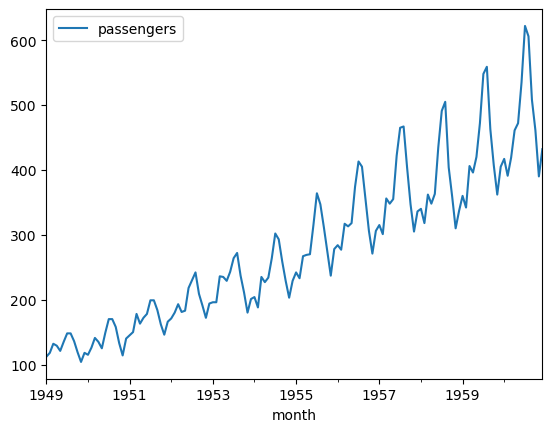

In [6]:
# TEST Cell

data.plot()

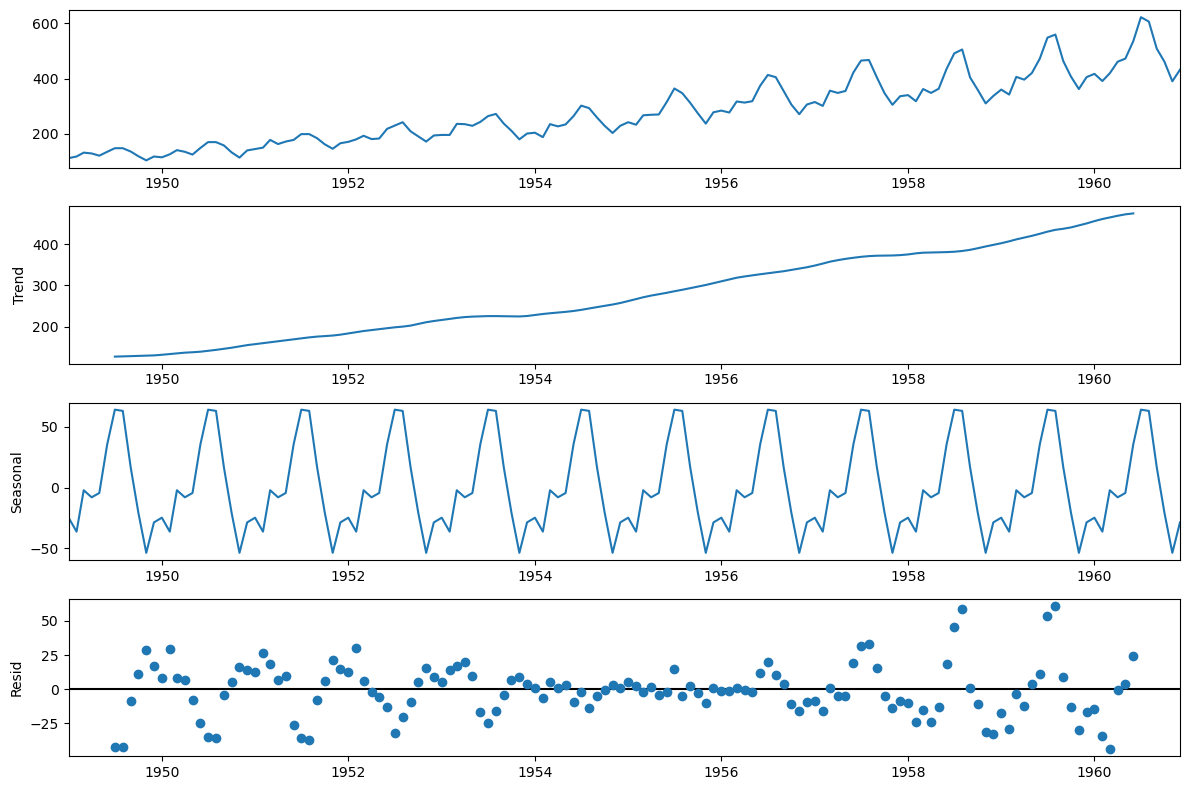

In [7]:
result = seasonal_decompose(data, model='additive', period=12) # period는 seaonal의 주기
plt.rcParams['figure.figsize'] = [12, 8]

# 명확하게 추세나 계절성이 보인다
result.plot()
plt.show()

In [8]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

In [11]:
diff_train_data = train_data.copy()
diff_train_data = diff_train_data['passengers'].diff()
diff_train_data = diff_train_data.dropna()
diff_train_data

month
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
1949-06-01    14.0
              ... 
1958-03-01    44.0
1958-04-01   -14.0
1958-05-01    15.0
1958-06-01    72.0
1958-07-01    56.0
Name: passengers, Length: 114, dtype: float64

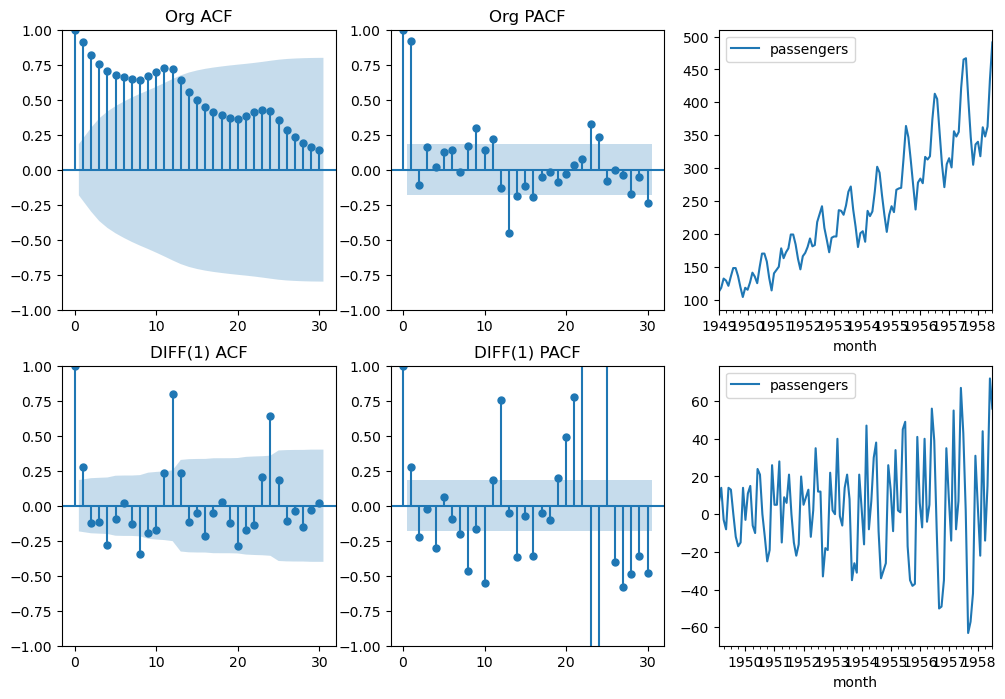

In [12]:
fig, ax = plt.subplots(2,3)
train_data.plot(ax=ax[0,2])
plot_acf(train_data, ax=ax[0, 0], lags=30,title= 'Org ACF')
plot_pacf(train_data, ax=ax[0, 1], lags=30,title= 'Org PACF')
plot_acf(diff_train_data, ax=ax[1, 0], lags=30,title= 'DIFF(1) ACF')
plot_pacf(diff_train_data, ax=ax[1, 1], lags=30,title= 'DIFF(1) PACF')
train_data.diff(1).dropna().plot(ax=ax[1,2])
plt.show()

In [1230]:
adfuller(train_data)[1],adfuller(np.log(train_data))[1] ,adfuller(train_data.diff(1).dropna())[1] 

(0.9170517285875917, 0.4966260517086155, 0.10612609999673256)

In [13]:
model = ARIMA(train_data, order=(1,1,0))
model_result = model.fit()
model_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             passengers   No. Observations:                  115
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -532.268
Date:                Fri, 03 Nov 2023   AIC                           1068.536
Time:                        22:00:22   BIC                           1074.008
Sample:                    01-01-1949   HQIC                          1070.757
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2904      0.089      3.278      0.001       0.117       0.464
sigma2       664.7320     89.253      7.448      0.000     489.800     839.664
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                 3.25
Prob(Q):                              0.57   Prob(JB):                         0.20
Heteroskedasticity (H):               6.18   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
auto_model = auto_arima(train_data, start_p=0, d=0, start_q=0, max_p=5, max_d=3, max_q=5, trace = True, alpha=0.05)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1367.727, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1092.214, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1604.291, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1083.134, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1081.054, Time=0.10 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=1083.048, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1074.610, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1073.718, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1078.074, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1074.541, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1076.299, Time=0.09 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1074.529, Time=0.06 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] interc

In [15]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -531.859
Date:                Fri, 03 Nov 2023   AIC                           1073.718
Time:                        22:00:26   BIC                           1087.443
Sample:                    01-01-1949   HQIC                          1079.289
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     12.5015     12.703      0.984      0.325     -12.396      37.399
ar.L1          0.4758      0.115      4.136      0.000       0.250       0.701
ar.L2          0.4765      0.122      3.912      0.000       0.238       0.715
ma.L1          0.9077      0.060     15.192      0.000       0.791       1.025
sigma2       587.7947    102.211      5.751      0.000     387.465     788.124
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 3.24
Prob(Q):                              0.73   Prob(JB):                         0.20
Heteroskedasticity (H):               4.80   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='month'>

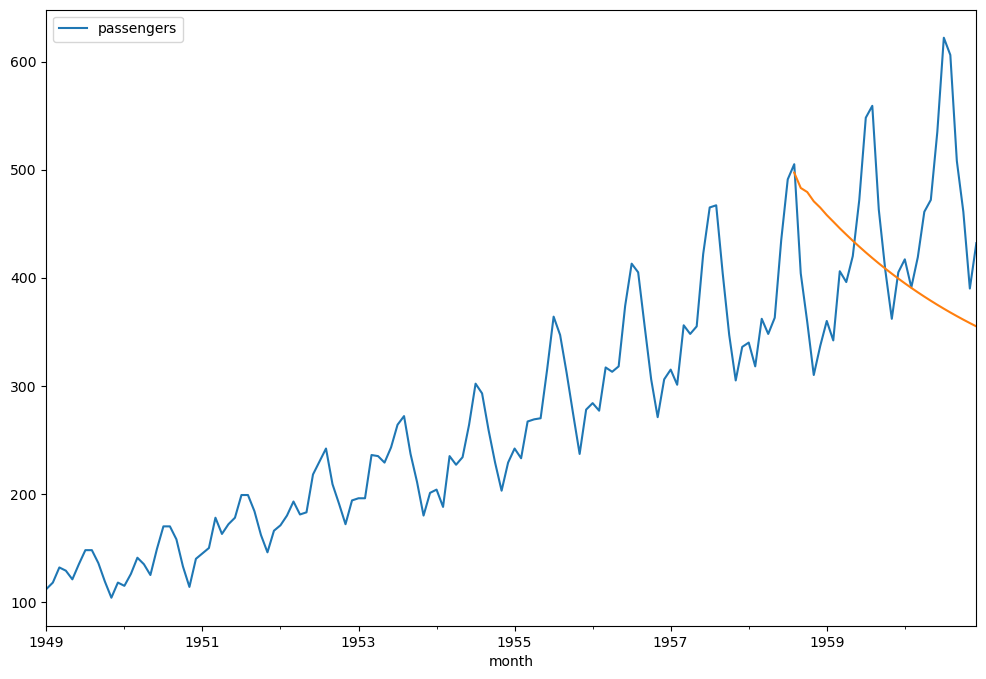

In [16]:
data.plot()
auto_model.predict(len(test_data)).plot()

# Forecast

In [17]:
model = ARIMA(train_data, order=(2,1,1))
model_opt_fit = model.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             passengers   No. Observations:                  115
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -525.324
Date:                Fri, 03 Nov 2023   AIC                           1058.648
Time:                        22:00:40   BIC                           1069.592
Sample:                    01-01-1949   HQIC                          1063.089
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0717      0.111      9.615      0.000       0.853       1.290
ar.L2         -0.4397      0.105     -4.177      0.000      -0.646      -0.233
ma.L1         -0.8309      0.110     -7.556      0.000      -1.046      -0.615
sigma2       585.6414     79.145      7.400      0.000     430.519     740.764
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):                 7.55
Prob(Q):                              0.56   Prob(JB):                         0.02
Heteroskedasticity (H):               6.24   Skew:                             0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
model_opt_fit.get_forecast(len(test_data))
model_opt_fit.predict(len(test_data))

1951-06-01    170.502775
1951-07-01    174.243849
1951-08-01    198.298869
1951-09-01    189.183780
1951-10-01    172.231420
                 ...    
1958-03-01    318.110952
1958-04-01    382.362889
1958-05-01    342.199957
1958-06-01    367.949520
1958-07-01    449.857914
Freq: MS, Name: predicted_mean, Length: 86, dtype: float64

In [19]:
predicted_value = model_opt_fit.forecast(len(test_data))
predicted_lb = model_opt_fit.get_forecast(len(test_data)).conf_int(0.05).iloc[:,0]
predicted_ub = model_opt_fit.get_forecast(len(test_data)).conf_int(0.05).iloc[:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

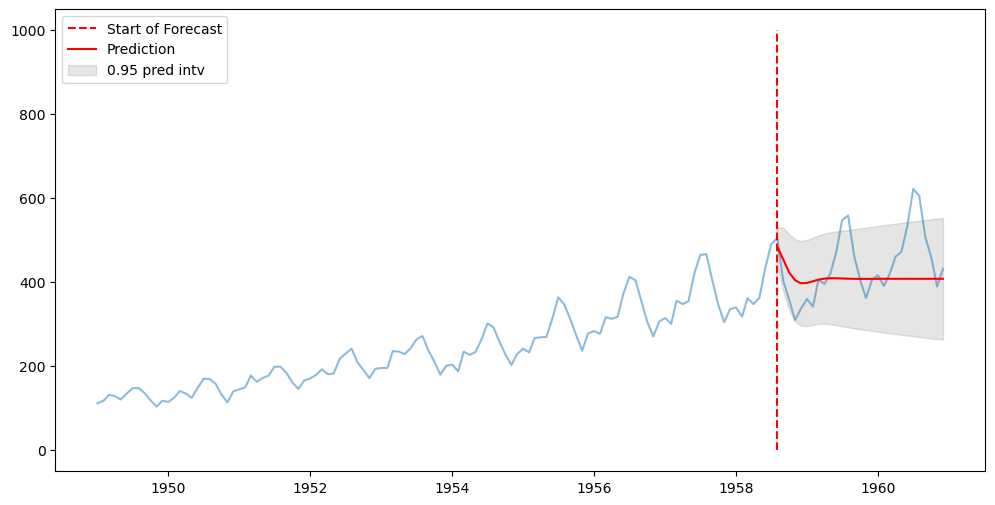

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data, alpha=0.5)
ax.vlines(predicted_value.index[0], 0, 1000, linestyle='--', color='r', label ='Start of Forecast')
ax.plot(predicted_value, c='r', label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 pred intv')
ax.legend(loc='upper left')
plt.show()

# SARIMA

In [28]:
auto_sarima_model = auto_arima(train_data, start_p=0, d=0, start_q=0, max_p=5, max_d=3, max_q=5,
                               start_P=0, D=None, start_Q=0, max_P=5, max_D=2, max_Q=5,  m=12, # m = seasonal param
                               seasonal= True, trace = True, alpha=0.05, maxiter= 50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=863.433, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=759.637, Time=0.17 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=813.215, Time=0.15 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1014.891, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=759.939, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=761.588, Time=0.39 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=761.616, Time=0.30 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=759.665, Time=0.13 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=763.527, Time=0.76 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=865.387, Time=0.13 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=760.731, Time=0.25 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=761.000, Time=0.23 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=813.330, Time=0.16 sec
 ARIMA(2,0,1)(1,1,0)[12] intercept   : AIC=760.939, Time=0.44 sec
 ARIMA(1,0,0)(1,1,0)[12]        

In [29]:
auto_sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                -375.818
Date:                            Fri, 03 Nov 2023   AIC                            759.637
Time:                                    22:02:17   BIC                            770.175
Sample:                                01-01-1949   HQIC                           763.905
                                     - 07-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.0280      2.120      2.843      0.004       1.872      10.184
ar.L1          0.8163      0.066     12.399      0.000       0.687       0.945
ar.S.L12      -0.1530      0.097     -1.581      0.114      -0.343       0.037
sigma2        85.3079     13.250      6.438      0.000      59.338     111.278
===================================================================================
Ljung-Box (L1) (Q):                   0.79   Jarque-Bera (JB):                 2.93
Prob(Q):                              0.37   Prob(JB):                         0.23
Heteroskedasticity (H):               0.98   Skew:                             0.39
Prob(H) (two-sided):                  0.95   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
sarima_model = SARIMAX(train_data, order=(1,0,0), seasonal_order= (1,1,0,12)).fit()
display(sarima_model.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75914D+00    |proj g|=  1.75971D-01

At iterate    5    f=  3.30851D+00    |proj g|=  6.41303D-03

At iterate   10    f=  3.30650D+00    |proj g|=  1.91159D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     24      1     0     0   2.912D-06   3.306D+00
  F =   3.3064864049571274     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         passengers   No. Observations:                  115
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                -380.246
Date:                            Fri, 03 Nov 2023   AIC                            766.492
Time:                                    22:02:19   BIC                            774.396
Sample:                                01-01-1949   HQIC                           769.693
                                     - 07-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9621      0.027     35.836      0.000       0.910       1.015
ar.S.L12      -0.1508      0.086     -1.759      0.078      -0.319       0.017
sigma2        91.7992     14.139      6.493      0.000      64.087     119.511
===================================================================================
Ljung-Box (L1) (Q):                   3.25   Jarque-Bera (JB):                 2.31
Prob(Q):                              0.07   Prob(JB):                         0.32
Heteroskedasticity (H):               0.93   Skew:                             0.33
Prob(H) (two-sided):                  0.84   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
predicted_value = sarima_model.forecast(len(test_data))
predicted_lb = sarima_model.get_forecast(len(test_data)).conf_int(0.05).iloc[:,0]
predicted_ub = sarima_model.get_forecast(len(test_data)).conf_int(0.05).iloc[:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

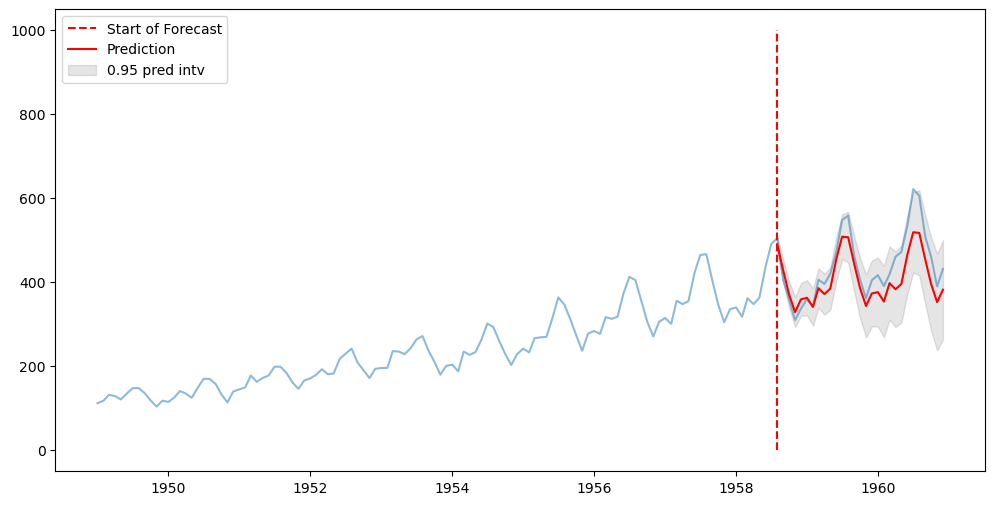

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data, alpha=0.5)
ax.vlines(predicted_value.index[0], 0, 1000, linestyle='--', color='r', label ='Start of Forecast')
ax.plot(predicted_value, c='r', label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 pred intv')
ax.legend(loc='upper left')
plt.show()

# 2 Stock

In [34]:
def get_code(df, name):
    code = df.query("name=='{}'".format(name))['code'].to_string(index=False)
    code = code.strip()
    return code

In [35]:
code_data = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]
code_data.head()

,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
0,AJ네트웍스,95570,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,손삼달,http://www.ajnet.co.kr,서울특별시
1,BGF리테일,282330,종합 소매업,체인화 편의점,2017-12-08,12월,민승배,http://www.bgfretail.com,서울특별시
2,BNK금융지주,138930,기타 금융업,금융지주회사,2011-03-30,12월,빈대인,http://www.bnkfg.com,부산광역시
3,DSR,155660,1차 비철금속 제조업,합섬섬유로프,2013-05-15,12월,홍석빈,http://www.dsr.com,부산광역시
4,HDC현대산업개발,294870,건물 건설업,"외주주택, 자체공사, 일반건축, 토목 등",2018-06-12,12월,"최익훈, 정익희, 김회언 (각자 대표이사)",http://www.hdc-dvp.com,서울특별시


In [36]:
code_data = code_data[['회사명', '종목코드']]
code_data = code_data.rename(columns={'회사명' : 'name', '종목코드' : 'code'})
code_data.code = code_data.code.map('{:06d}'.format)

In [41]:
import datetime as dt

In [42]:

company = 'TATAELXSI.NS'

# Define a start date and End Date
start = dt.datetime(2020,1,1)
end =  dt.datetime(2022,1,1)

# Read Stock Price Data 
data = yf.download(company)

data.tail(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-20,7736.600098,7738.000000,7501.000000,7564.399902,7564.399902,119490
2023-10-23,7564.399902,7612.000000,7300.000000,7336.450195,7336.450195,117797
2023-10-25,7399.850098,7590.000000,7381.500000,7545.250000,7545.250000,198994
2023-10-26,7500.000000,7520.000000,7380.000000,7463.500000,7463.500000,126826
2023-10-27,7500.000000,7655.000000,7500.000000,7601.600098,7601.600098,110987
2023-10-30,7660.000000,7685.000000,7580.549805,7639.250000,7639.250000,110688
2023-10-31,7650.950195,7680.950195,7585.000000,7625.200195,7625.200195,61348
2023-11-01,7650.000000,7657.750000,7450.000000,7483.399902,7483.399902,87104
2023-11-02,7550.950195,7587.950195,7413.700195,7496.899902,7496.899902,105161


In [43]:
start = dt.datetime(2020,1,1)
end =  dt.datetime(2022,1,1)

stock_code = get_code(code_data, '삼성전자')
stock_code = stock_code + '.KS'
ticker = yf.Ticker(stock_code)
# stock_data = yf.download('GOOGL')
stock_data = ticker.history(
               interval='1d',
               start='2010-01-01',
               end='2023-03-07',
               actions=True,
               auto_adjust=True)

In [44]:
stock_data = stock_data[['Close']]
stock_data

,Close
Date,
2010-01-04 00:00:00+09:00,12509.083008
2010-01-05 00:00:00+09:00,12710.094727
2010-01-06 00:00:00+09:00,13003.881836
2010-01-07 00:00:00+09:00,12570.933594
2010-01-08 00:00:00+09:00,12694.632812
...,...
2023-02-27 00:00:00+09:00,59852.980469
2023-02-28 00:00:00+09:00,59951.906250
2023-03-02 00:00:00+09:00,60149.769531


In [45]:
train_data, test_data = train_test_split(stock_data, test_size=0.05, shuffle=False)

<Axes: xlabel='Date'>

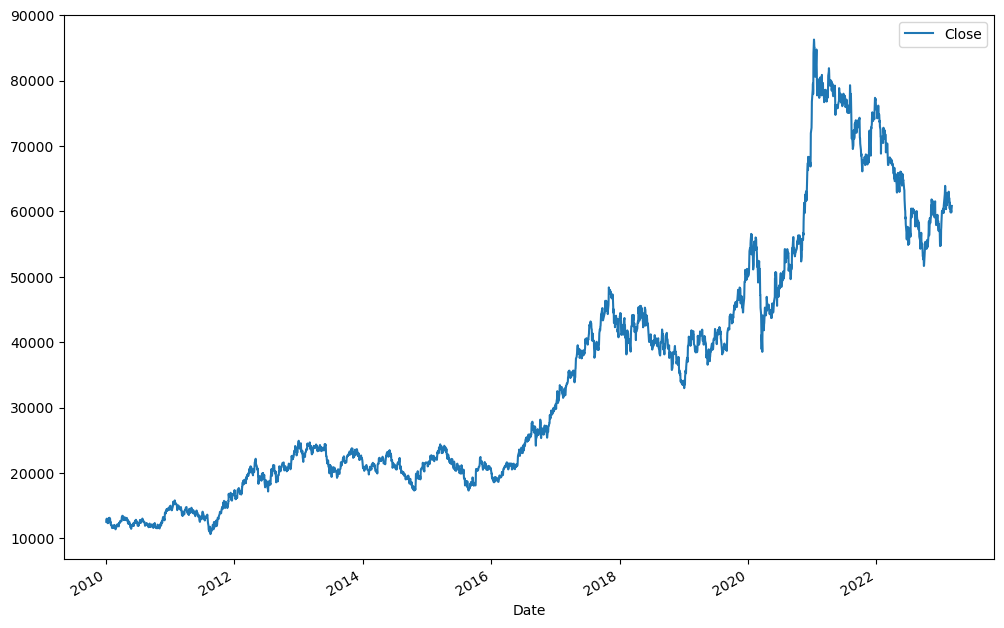

In [46]:
stock_data.plot()

In [47]:
diff_train_data = train_data.copy()
diff_train_data = diff_train_data['Close'].diff()
diff_train_data = diff_train_data.dropna()
diff_train_data

Date
2010-01-05 00:00:00+09:00     201.011719
2010-01-06 00:00:00+09:00     293.787109
2010-01-07 00:00:00+09:00    -432.948242
2010-01-08 00:00:00+09:00     123.699219
2010-01-11 00:00:00+09:00    -371.102539
                                ...     
2022-07-01 00:00:00+09:00    -781.160156
2022-07-04 00:00:00+09:00     878.808594
2022-07-05 00:00:00+09:00      97.644531
2022-07-06 00:00:00+09:00    -781.164062
2022-07-07 00:00:00+09:00    1757.609375
Name: Close, Length: 3084, dtype: float64

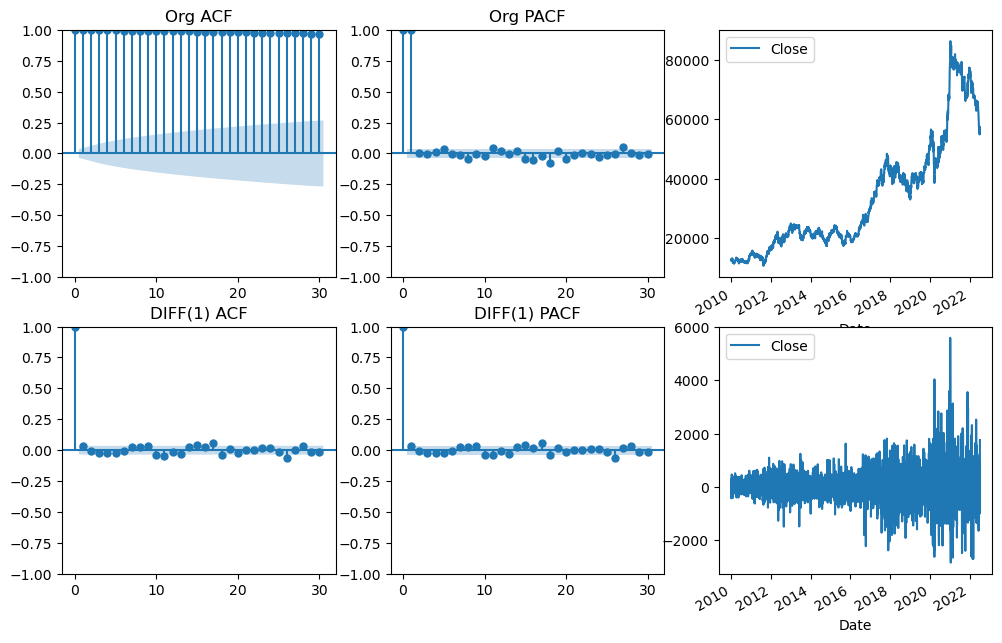

In [48]:
fig, ax = plt.subplots(2,3)
train_data.plot(ax=ax[0,2])
plot_acf(train_data, ax=ax[0, 0], lags=30,title= 'Org ACF')
plot_pacf(train_data, ax=ax[0, 1], lags=30,title= 'Org PACF')
plot_acf(diff_train_data, ax=ax[1, 0], lags=30,title= 'DIFF(1) ACF')
plot_pacf(diff_train_data, ax=ax[1, 1], lags=30,title= 'DIFF(1) PACF')
train_data.diff(1).dropna().plot(ax=ax[1,2])
plt.show()

In [49]:
auto_model = auto_arima(train_data, start_p=0, d=1, start_q=0, max_p=5, max_d=3, max_q=5, trace = True, alpha=0.05)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=48260.434, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=48257.880, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=48257.852, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=48260.175, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=48259.850, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=48259.846, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=48261.512, Time=1.57 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=48257.462, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=48259.460, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=48259.462, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=48257.487, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=48261.461, Time=0.22 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.030 seconds


In [51]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3085
Model:               SARIMAX(0, 1, 1)   Log Likelihood              -24126.731
Date:                Fri, 03 Nov 2023   AIC                          48257.462
Time:                        22:03:41   BIC                          48269.530
Sample:                             0   HQIC                         48261.796
                               - 3085                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0390      0.010      3.749      0.000       0.019       0.059
sigma2      3.657e+05   4433.093     82.491      0.000    3.57e+05    3.74e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6086.65
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               7.96   Skew:                             0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
arima_model = ARIMA(train_data, order=(0,1,1)).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 3085
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -24126.731
Date:                Fri, 03 Nov 2023   AIC                          48257.462
Time:                        22:03:41   BIC                          48269.530
Sample:                             0   HQIC                         48261.796
                               - 3085                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0390      0.010      3.749      0.000       0.019       0.059
sigma2      3.657e+05   4433.093     82.491      0.000    3.57e+05    3.74e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6086.65
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               7.96   Skew:                             0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
predicted_value = arima_model.forecast(len(test_data))
predicted_index = test_data.index
predicted_lb = arima_model.get_forecast(len(test_data)).conf_int(0.05).iloc[:,0]
predicted_ub = arima_model.get_forecast(len(test_data)).conf_int(0.05).iloc[:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)
r2

-0.37208089694297675

In [54]:
predicted_value.index = predict_index

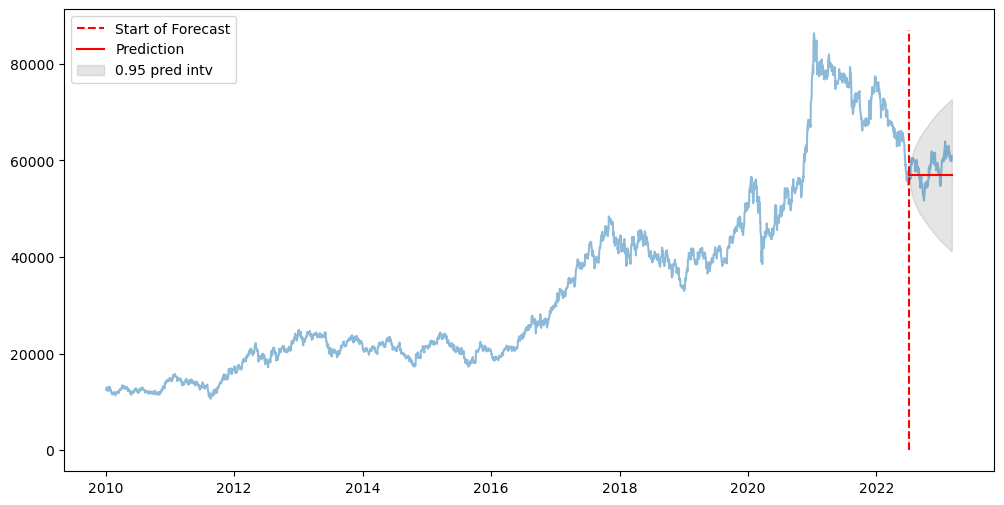

In [56]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(stock_data.Close, alpha=0.5)
ax.vlines(predicted_value.index[0], 0, max(predicted_value + 3e04), linestyle='--', color='r', label ='Start of Forecast')
ax.plot(predicted_value, c='r', label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 pred intv')
ax.legend(loc='upper left')
plt.show()

In [63]:
# solve using prophet

In [64]:
stock_data_prophet = stock_data[['Close']]
stock_data_prophet = stock_data_prophet.reset_index()
stock_data_prophet.columns = ['ds', 'y']
stock_data_prophet.ds = pd.to_datetime(stock_data_prophet.ds)
stock_data_prophet['ds'] = stock_data_prophet['ds'].dt.strftime('%Y-%m-%d')

In [65]:
stock_data_prophet_training, stock_data_prophet_test = train_test_split(stock_data_prophet, test_size=0.2, shuffle=False)

In [68]:
future = pd.DataFrame([stock_data_prophet.index])
future = future.T
future.columns = ['ds']
future['ds'] = pd.to_datetime(future['ds'])
future['ds'] = future['ds'].dt.strftime('%Y-%m-%d')

In [69]:
# future = m.make_future_dataframe(len(stock_data_prophet_test))
future

,ds
0,1970-01-01
1,1970-01-01
2,1970-01-01
3,1970-01-01
4,1970-01-01
...,...
3243,1970-01-01
3244,1970-01-01
3245,1970-01-01
3246,1970-01-01


In [70]:
m = Prophet()
m.fit(stock_data_prophet_training)

future = m.make_future_dataframe(len(stock_data_prophet_test))
forecast = m.predict(future)
forecast

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-04,11786.020935,9269.724900,14350.793922,11786.020935,11786.020935,108.686096,108.686096,108.686096,-157.066442,-157.066442,-157.066442,265.752538,265.752538,265.752538,0.0,0.0,0.0,11894.707031
1,2010-01-05,11790.262428,9563.629196,14453.492907,11790.262428,11790.262428,185.554113,185.554113,185.554113,-103.277850,-103.277850,-103.277850,288.831963,288.831963,288.831963,0.0,0.0,0.0,11975.816541
2,2010-01-06,11794.503921,9470.259144,14732.578068,11794.503921,11794.503921,164.431101,164.431101,164.431101,-150.244942,-150.244942,-150.244942,314.676044,314.676044,314.676044,0.0,0.0,0.0,11958.935023
3,2010-01-07,11798.745415,9282.325466,14669.366069,11798.745415,11798.745415,257.772099,257.772099,257.772099,-85.267392,-85.267392,-85.267392,343.039491,343.039491,343.039491,0.0,0.0,0.0,12056.517513
4,2010-01-08,11802.986908,9542.300036,14501.085442,11802.986908,11802.986908,224.108042,224.108042,224.108042,-149.500787,-149.500787,-149.500787,373.608829,373.608829,373.608829,0.0,0.0,0.0,12027.094949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,2022-04-21,55361.947106,45797.148690,66935.702412,44992.916009,66055.445660,831.104269,831.104269,831.104269,-85.267392,-85.267392,-85.267392,916.371661,916.371661,916.371661,0.0,0.0,0.0,56193.051375
3244,2022-04-22,55373.852877,45780.496999,66924.042645,44973.865918,66097.880672,770.372064,770.372064,770.372064,-149.500787,-149.500787,-149.500787,919.872851,919.872851,919.872851,0.0,0.0,0.0,56144.224940
3245,2022-04-23,55385.758647,46042.497510,67306.192862,44954.691703,66141.458660,1243.112897,1243.112897,1243.112897,322.678806,322.678806,322.678806,920.434092,920.434092,920.434092,0.0,0.0,0.0,56628.871544
3246,2022-04-24,55397.664418,46061.463066,67276.221926,44935.393363,66172.281861,1240.577719,1240.577719,1240.577719,322.678608,322.678608,322.678608,917.899110,917.899110,917.899110,0.0,0.0,0.0,56638.242136


[]

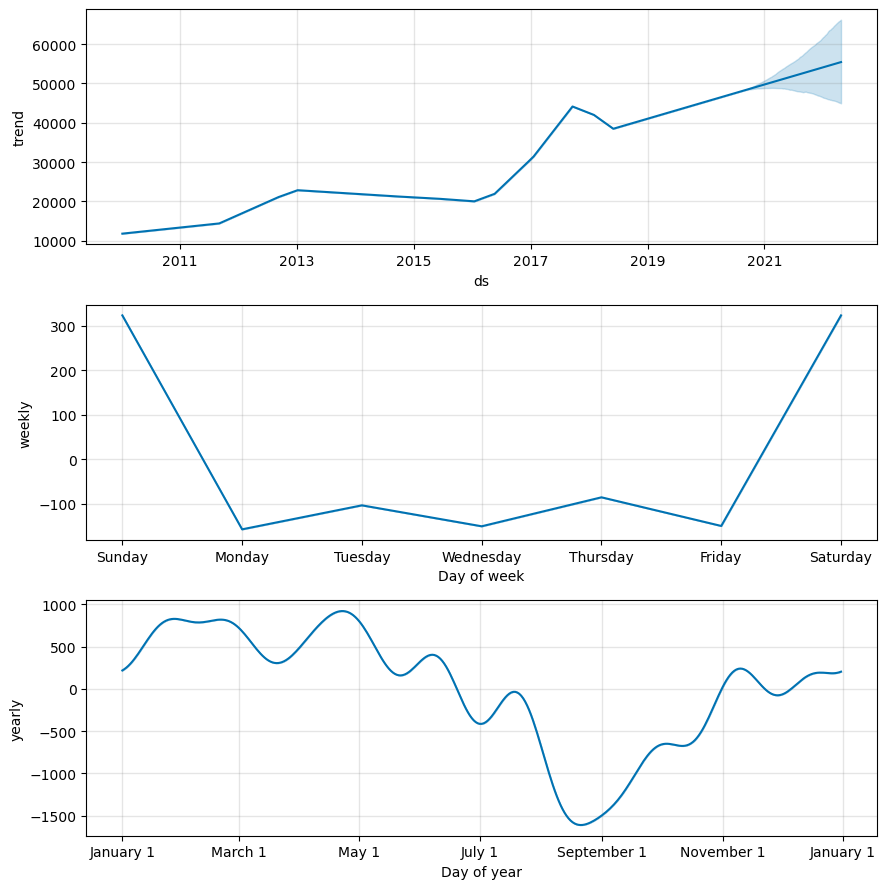

In [72]:
m.plot_components(forecast)
plt.plot()

In [73]:
stock_data_prophet_test['ds']

2598    2020-07-15
2599    2020-07-16
2600    2020-07-17
2601    2020-07-20
2602    2020-07-21
           ...    
3243    2023-02-27
3244    2023-02-28
3245    2023-03-02
3246    2023-03-03
3247    2023-03-06
Name: ds, Length: 650, dtype: object

[]

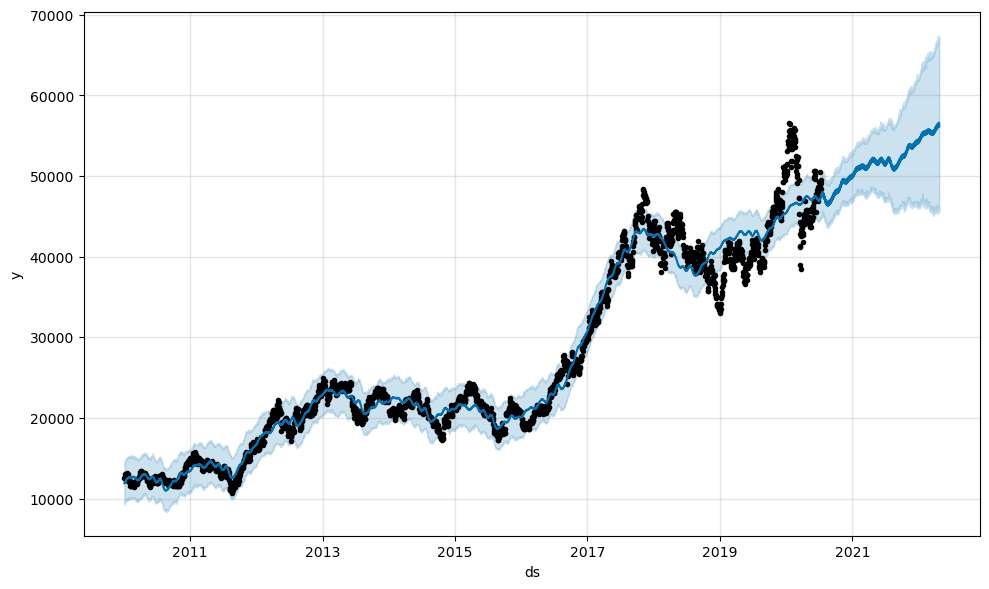

In [74]:
m.plot(forecast) # 파란색은 예측선, 검정색은 실제 데이터
# plt.scatter(x = stock_data_prophet_test['ds'], y = stock_data_prophet_test['y'])
plt.plot()

In [1287]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3243,2022-04-21,55966.371275,46258.802347,68264.014229,45681.041260,67026.465991,838.813335,838.813335,838.813335,-85.371415,-85.371415,-85.371415,924.184750,924.184750,924.184750,0.0,0.0,0.0,56805.184610
3244,2022-04-22,55978.409092,46503.243801,68464.233242,45683.440787,67084.287600,777.344762,777.344762,777.344762,-150.366210,-150.366210,-150.366210,927.710972,927.710972,927.710972,0.0,0.0,0.0,56755.753854
3245,2022-04-23,55990.446908,46093.646006,69325.060721,45675.110159,67146.140454,1252.616286,1252.616286,1252.616286,324.351615,324.351615,324.351615,928.264672,928.264672,928.264672,0.0,0.0,0.0,57243.063194
3246,2022-04-24,56002.484724,46760.097447,69000.751909,45659.413935,67207.993307,1250.039827,1250.039827,1250.039827,324.351471,324.351471,324.351471,925.688356,925.688356,925.688356,0.0,0.0,0.0,57252.524551
3247,2022-04-25,56014.522541,46073.403237,68673.576910,45644.398005,67269.846160,761.736124,761.736124,761.736124,-158.107010,-158.107010,-158.107010,919.843134,919.843134,919.843134,0.0,0.0,0.0,56776.258664


## Prophet

# Trend
- 데이터의 장기적인 증가또는 감소

# ARIMA vs Prophet

- In summary, ARIMA is a good choice for short-term forecasting of stationary time series data with a limited number of parameters, while Prophet is better suited for longer-term forecasting of time series data with complex patterns, such as multiple seasonality components and irregularities in the data.



# PROPHET
- 사용하기 쉽다
- 정확도가 높고 빠르며 직관적인 파라미터로 모델 수정이 용이하다는 장점을 갖고 있습니다

Prophet 모델의 주요 구성요소는 Trend, Seasonality, Holiday 입니다. 이 세가지를 결합하면 아래의 공식으로 나타낼 수 있습니다.

```
y(t)=g(t)+s(t)+h(t)+ϵi
g(t) : piecewise linear or logistic growth curve for modelling non-periodic changes in time series
s(t): periodic changes (e.g. weekly/yearly seasonality)
h(t) : effects of holidays (user provided) with irregular schedules
ϵi : error term accounts for any unusual changes not accommodated by the model
위에서 Trend 를 구성하는 g(t) 함수는 주기적이지 않은 변화인 트렌드를 나타냅니다. 부분적으로 선형 또는 logistic 곡선으로 이루어져 있습니다. 그리고 Seasonality 인 s(t) 함수는 weekly, yearly 등 주기적으로 나타나는 패턴들을 포함합니다. 
Holiday를 나타내는  h(t) 함수는 휴일과 같이 불규칙한 이벤트들을 나타냅니다. 만약 특정 기간에 값이 비정상적으로 증가 또는, 감소했다면, holiday로 정의하여 모델에 반영할 수 있습니다. 마지막으로 ϵi 는 정규분포라고 가정한 오차입니다.
```


In [1288]:
amazon = pd.read_csv('Prophet/data/AMAZON_stock.csv')
amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [1289]:
# 데이터는 ‘2017-01-01’ 에서 ‘2019-12-27’ 까지의 일자 ‘ds’ 별 실적값 ‘y’ 으로 구성되어 있습니다.
amazon_prophet = amazon[['Date','Close']]
amazon_prophet.columns = ['ds','y']

In [1290]:
amazon_prophet_train, amazon_prophet_test = train_test_split(amazon_prophet, test_size=0.2, shuffle=False)

In [1291]:
m = Prophet(growth='linear')
m.add_country_holidays(country_name='USA')
m.fit(amazon_prophet_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [1292]:
future = m.make_future_dataframe(periods=len(amazon_prophet_test)) # 데이터프레임 생성
forecast = m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-05-19,1006.290195,835.022102,1027.210618,1006.290195,1006.290195,0.0,0.0,0.0,0.0,...,6.945072,6.945072,6.945072,-82.540837,-82.540837,-82.540837,0.0,0.0,0.0,930.694431
1,2017-05-22,1001.247517,833.973468,1019.911575,1001.247517,1001.247517,0.0,0.0,0.0,0.0,...,4.824231,4.824231,4.824231,-82.042164,-82.042164,-82.042164,0.0,0.0,0.0,924.029584
2,2017-05-23,999.566624,838.564616,1023.838395,999.566624,999.566624,0.0,0.0,0.0,0.0,...,13.036197,13.036197,13.036197,-80.447626,-80.447626,-80.447626,0.0,0.0,0.0,932.155195
3,2017-05-24,997.885731,831.198524,1027.022855,997.885731,997.885731,0.0,0.0,0.0,0.0,...,13.866716,13.866716,13.866716,-78.227401,-78.227401,-78.227401,0.0,0.0,0.0,933.525046
4,2017-05-25,996.204838,840.282425,1031.504389,996.204838,996.204838,0.0,0.0,0.0,0.0,...,12.503709,12.503709,12.503709,-75.451712,-75.451712,-75.451712,0.0,0.0,0.0,933.256836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2022-01-22,3644.165495,2905.409903,4248.933906,2978.262564,4272.609301,0.0,0.0,0.0,0.0,...,-25.587969,-25.587969,-25.587969,-33.508689,-33.508689,-33.508689,0.0,0.0,0.0,3585.068837
1255,2022-01-23,3645.305885,2893.270174,4241.607577,2974.573553,4278.770077,0.0,0.0,0.0,0.0,...,-25.587957,-25.587957,-25.587957,-30.695561,-30.695561,-30.695561,0.0,0.0,0.0,3589.022367
1256,2022-01-24,3646.446276,2925.989886,4298.377206,2970.884542,4284.205181,0.0,0.0,0.0,0.0,...,4.824231,4.824231,4.824231,-27.717567,-27.717567,-27.717567,0.0,0.0,0.0,3623.552940
1257,2022-01-25,3647.586666,2936.131085,4311.091445,2967.195530,4291.572894,0.0,0.0,0.0,0.0,...,13.036197,13.036197,13.036197,-24.600456,-24.600456,-24.600456,0.0,0.0,0.0,3636.022406


[]

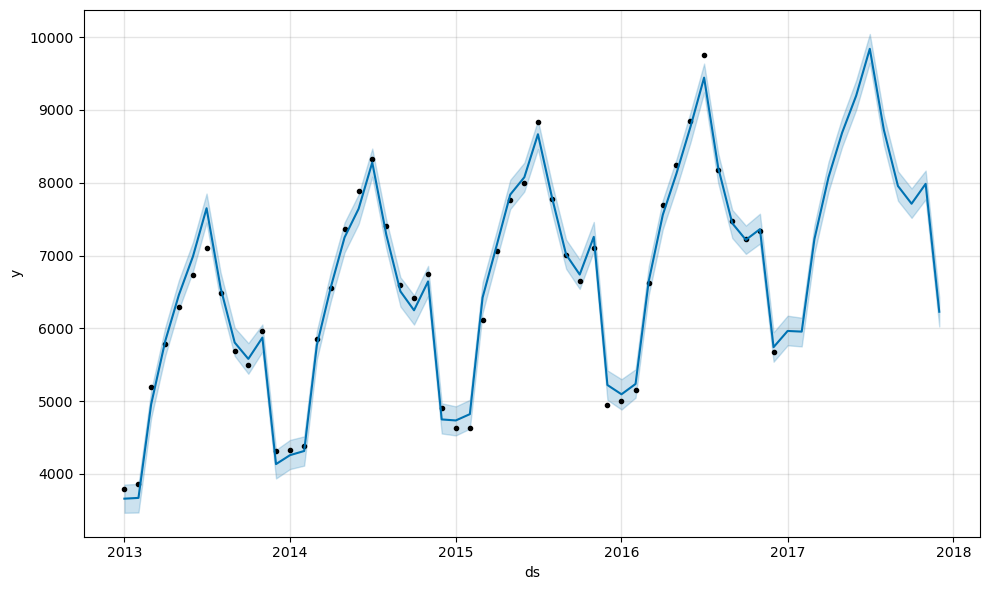

In [112]:
m.plot(forecast) # 파란색은 예측선, 검정색은 실제 데이터
plt.plot()

[]

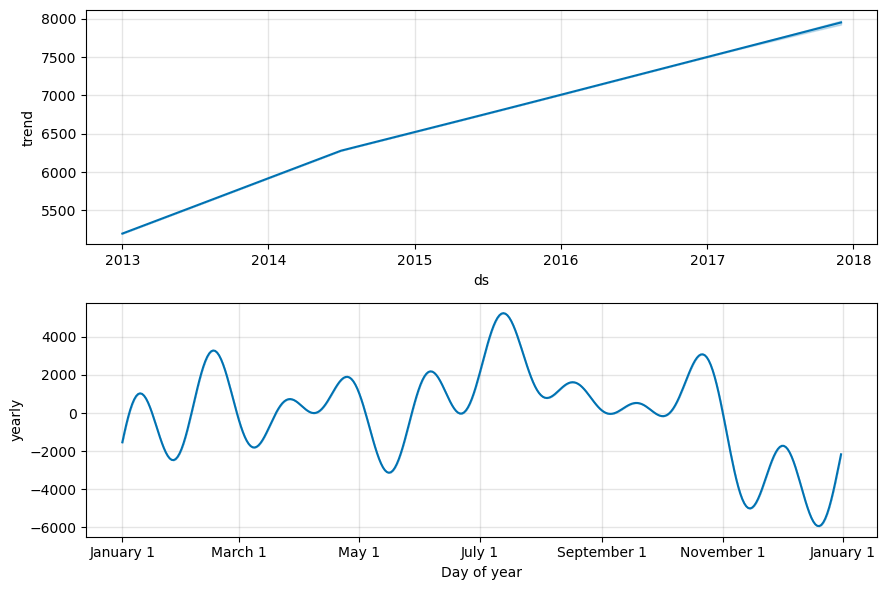

In [113]:
m.plot_components(forecast)
plt.plot()

1. Trend는 점점 증가하는 추세를 보입니다. 데이터의 Trend를 잘 잡아내지 못하는 것 같다면, changepoint_prior_scale 파라미터값을 높여주어 changepoint를 더 민감하게 감지하도록 할 수 있다. (changepoint란, Trend가 변화하는 지점을 의미)
2. ‘주 계절성’과 ‘연 계절성’을 의미합니다. Trend와 마찬가지로 Seasonality또한 seasonality_prior_scale 파라미터로 모델 반영 강도를 조절할 수 있습니다.

## Trend
- 모델의 Trend를 조절할 수 있는 파라미터는 다음과 같습니다.


|Parameter|Description|
|--|--|
|changepoints|트렌드 변화시점을 명시한 리스트값|
|changepoint_prior_scale|changepoint(trend) 의 유연성 조절(너무 높이면 오버피팅)|
|n_changepoints|changepoint 의 개수|
|changepoint_range|changepoint 설정 가능 범위. (기본적으로 데이터 중 80% 범위 내에서 changepoint를 설정)|


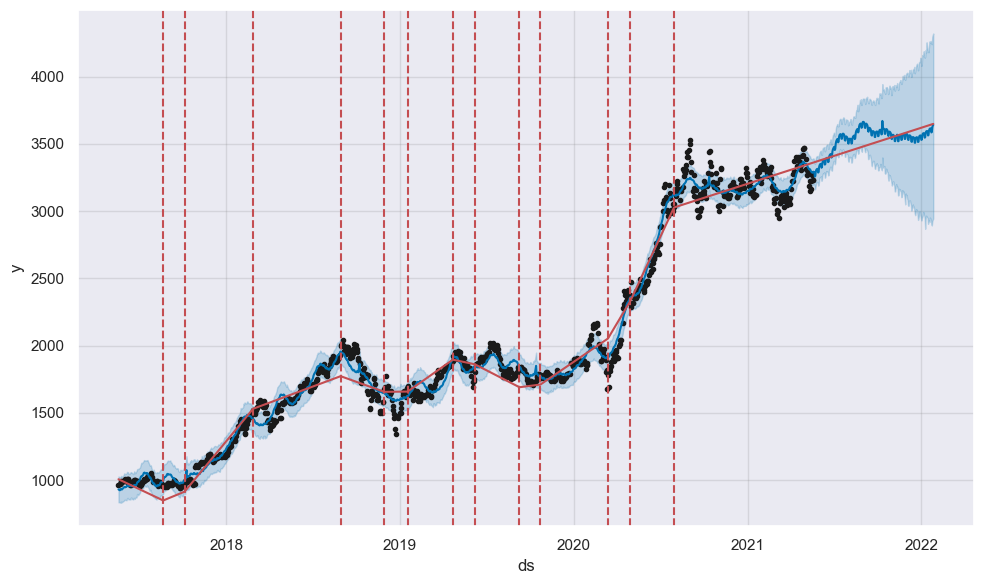

In [1295]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


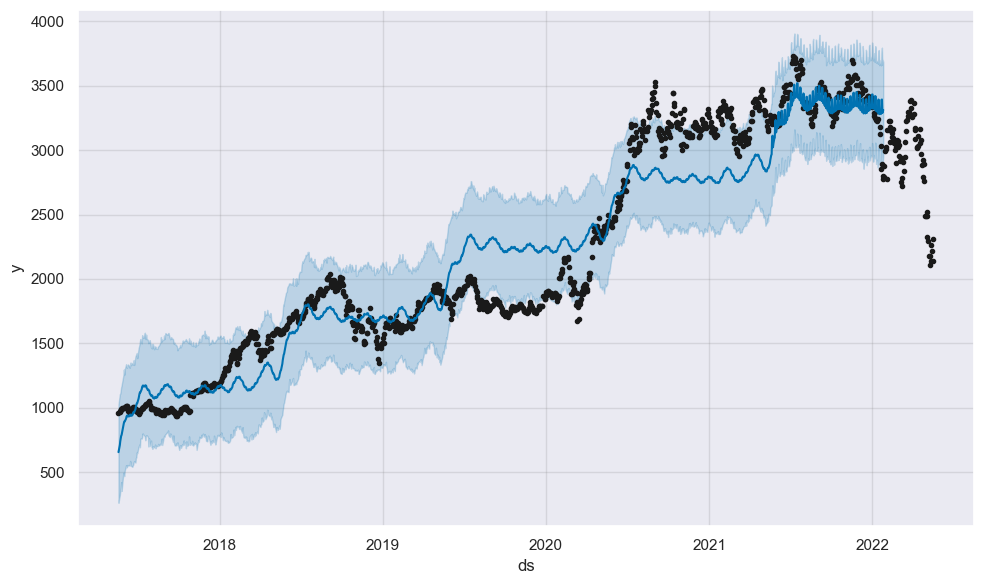

In [1296]:
m = Prophet(changepoints=['2018-01-01'])
forecast = m.fit(amazon_prophet).predict(future)
fig = m.plot(forecast)

# Seasonality

|Parameter|Description|
|--|--|
|yearly_seasonality|연 계절성|
|weekly_seasonality|주 계절성|
|daily_seasonality|일 계절성|
|seasonality_prior_scale|계절성 반영 강도|
|seasonality_mode|‘additive ‘ 인지 ‘multiplicative’ 인지|

- Additive Seasonality : Time series = Trend + Seasonality + Error
- Multiplicative Seasonality : Time series = Trend * Seasonality * Error
> 진폭이 일정하면 additive 아니면, multiplicative

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


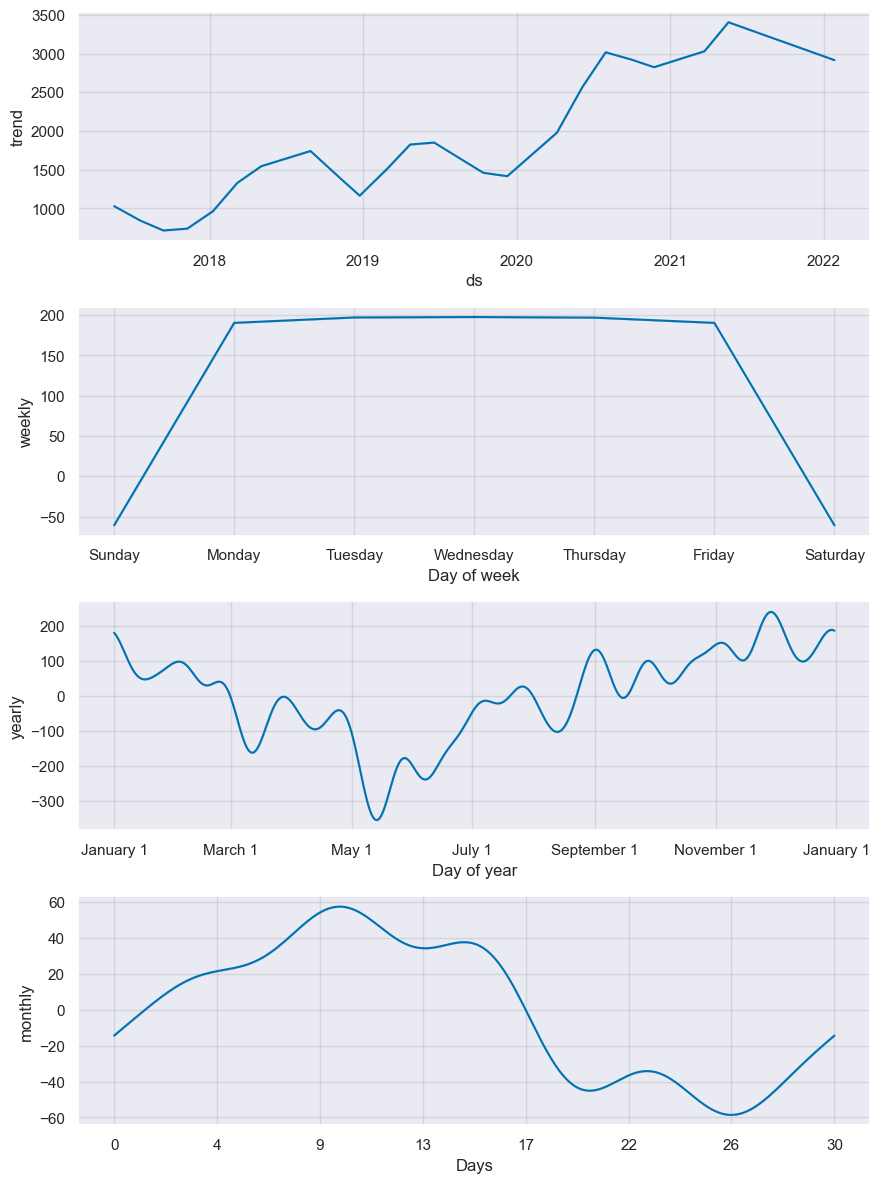

In [1297]:
m = Prophet(changepoint_prior_scale=0.3, weekly_seasonality=10, yearly_seasonality=20, daily_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5) # monthly는 미제공되나, 임의로 정의 가능
forecast = m.fit(amazon_prophet).predict(future)
fig = m.plot_components(forecast)

# Holiday

- 휴일이나 이벤트 날짜를 반영하여 정확도를 높일 수 있다
- 만약 휴일이 휴일 전,후에도 영향을 미친다면 해당일만큼 파라미터로 설정해 줄 수 있습니다. 예를 들어, 공휴일 영향이 그 다음날에도 영향을 미친다면 lower_window=0, upper_window=1 을 추가하면 된다
- m.add_country_holidays(country_name=’국가코드’)로 간단하게 국가 공휴일을 불러올 수도 있습니다. 하지만 모든 국가의 공휴일이 있는건 아니다

|Parameter|Description|
|--|--|
|holidays|휴일 또는 이벤트 기간을 명시한 데이터프레임|
|holiday_prior_scale|holiday 반영 강도|

In [1298]:
holiday = pd.DataFrame({
    'holiday': 'holiday',
    'ds': pd.concat([
        pd.Series(pd.date_range('2017-05-05', '2017-06-03', freq='D')),
        pd.Series(pd.date_range('2018-05-05', '2018-06-03', freq='D')),
        pd.Series(pd.date_range('2019-05-05', '2019-06-03', freq='D')),
        pd.Series(pd.date_range('2020-05-05', '2020-06-03', freq='D'))
    ])
    # lower_window = 0,
    # upper_window = 1
})

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


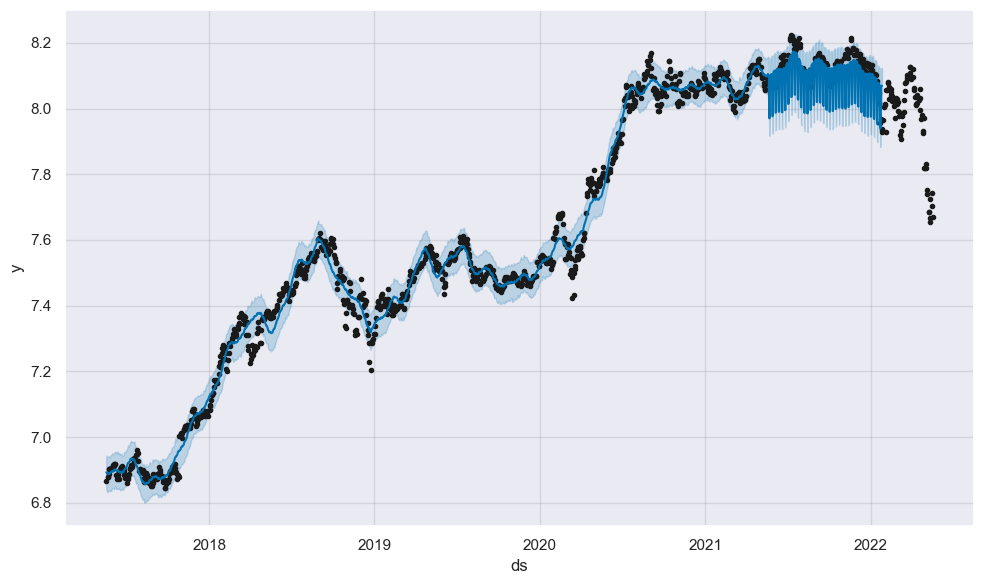

In [1312]:
m = Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=10, yearly_seasonality=10, daily_seasonality=False, #seasonality_mode='multiplicative',
    # holiday
#     holidays=holiday, holidays_prior_scale=3
)

# Specifying Custom Seasonalities
# m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
# m.add_country_holidays(country_name = 'Korea')
m.fit(amazon_prophet)
forecast = m.predict(future)

fig = m.plot(forecast) 

In [1313]:
amazon_prophet = amazon[['Date', 'Close']]

In [1314]:
amazon_prophet['log_close'] = np.log(amazon_prophet.Close)
amazon_prophet = amazon_prophet.drop(columns='Close')
amazon_prophet.columns = ['ds', 'y']
amazon_prophet

,ds,y
0,2017-05-19,6.866767
1,2017-05-22,6.877987
2,2017-05-23,6.878882
3,2017-05-24,6.887910
4,2017-05-25,6.901113
...,...,...
1254,2022-05-12,7.667911
1255,2022-05-13,7.723607
1256,2022-05-16,7.703554
1257,2022-05-17,7.743864


In [1315]:
amazon_prophet['ds'] =  pd.to_datetime(amazon_prophet.ds)

In [1316]:
amazon_prophet_arima = amazon_prophet.set_index('ds', drop=True)

In [1318]:
amazon_prophet_arima = amazon_prophet_arima.resample('D').ffill()

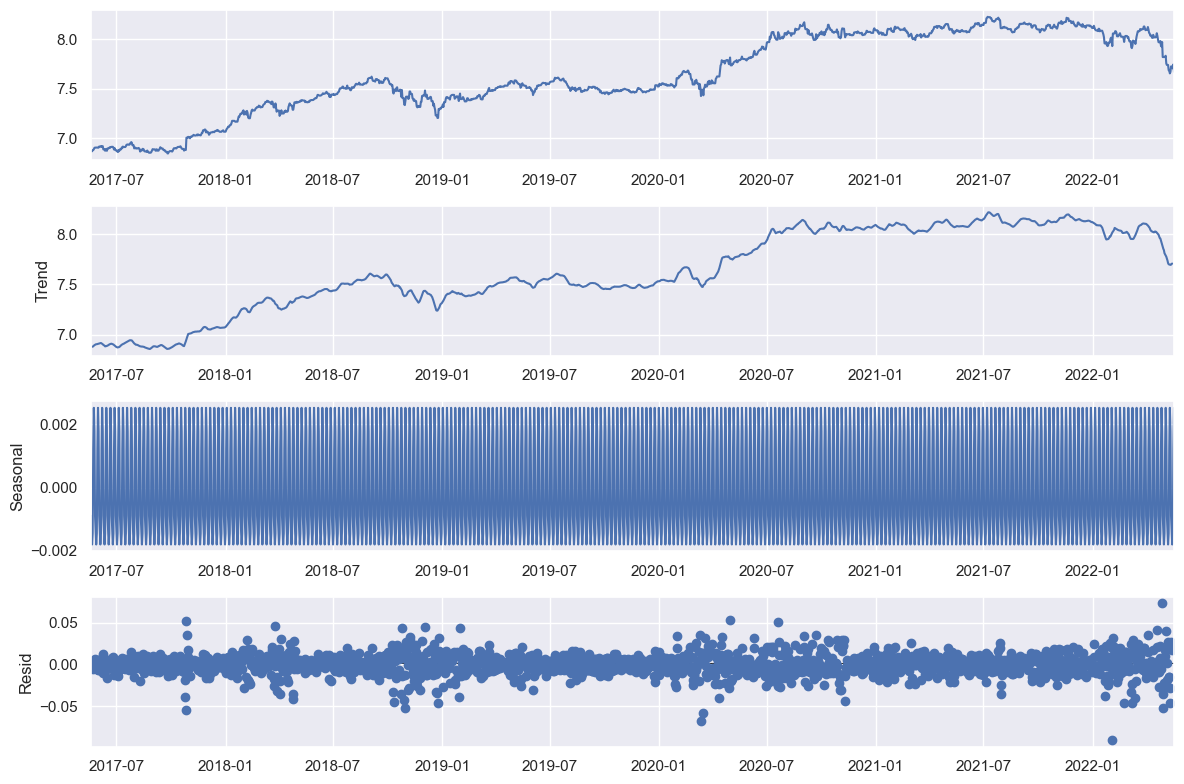

In [1319]:
result = seasonal_decompose(amazon_prophet_arima)
result.plot()
plt.show()

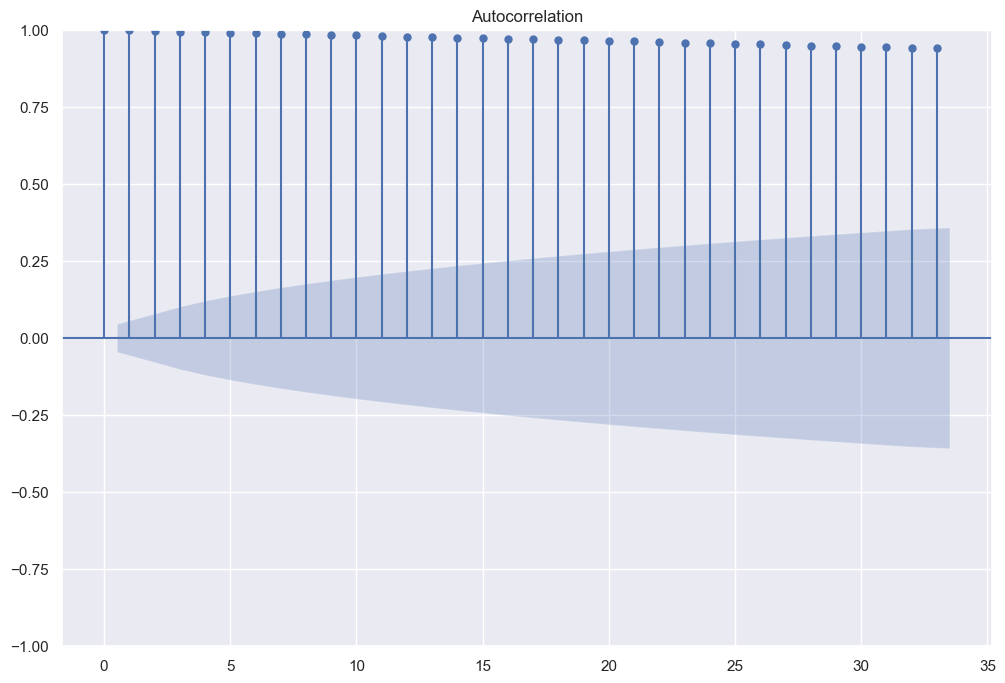

In [1320]:
plot_acf(amazon_prophet_arima)
plt.show()

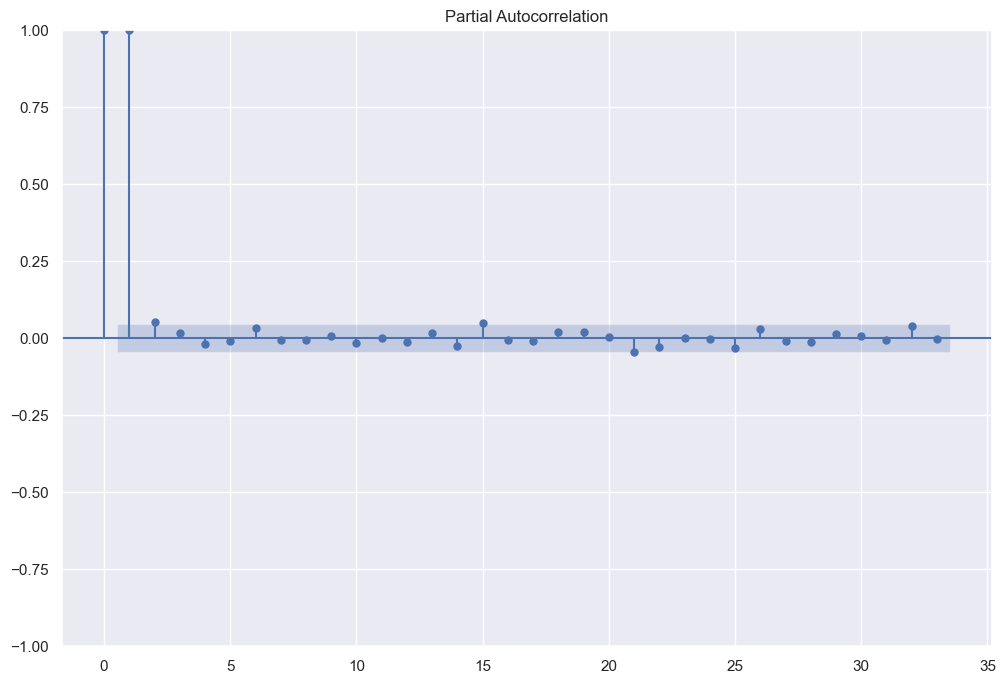

In [1321]:
plot_pacf(amazon_prophet_arima)
plt.show()

In [1322]:
model = ARIMA(amazon_prophet_arima, order=(0,0,3), trend='ct')
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1826
Model:                 ARIMA(0, 0, 3)   Log Likelihood                2846.994
Date:                Thu, 09 Mar 2023   AIC                          -5681.988
Time:                        17:20:09   BIC                          -5648.928
Sample:                    05-19-2017   HQIC                         -5669.793
                         - 05-18-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9996      0.010    730.363      0.000       6.981       7.018
x1             0.0007   8.63e-06     80.516      0.000       0.001       0.001
ma.L1          0.8419      0.008    107.271      0.000       0.826       0.857
ma.L2          0.8622      0.004    230.625      0.000       0.855       0.870
ma.L3          0.8837      0.008    112.031      0.000       0.868       0.899
sigma2         0.0026   8.56e-05     30.212      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                 677.28   Jarque-Bera (JB):               386.49
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.52   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# ARIMA 

In [75]:
data = pd.read_csv('./data/arima_data.csv', names=['day','price'])

In [76]:
data['day'] = pd.to_datetime(data['day'], format="%Y-%m-%d")
data.set_index('day', inplace=True)
data.head()

,price
day,
2013-01-01,3794
2013-02-01,3863
2013-03-01,5190
2013-04-01,5783
2013-05-01,6298


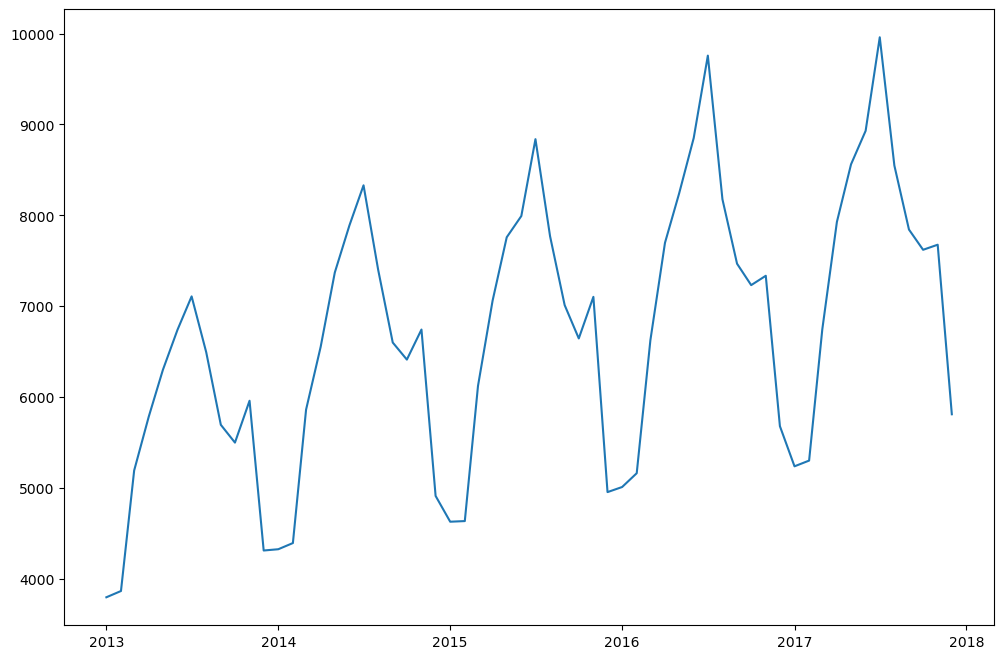

In [77]:
plt.plot(data.index, data['price'])

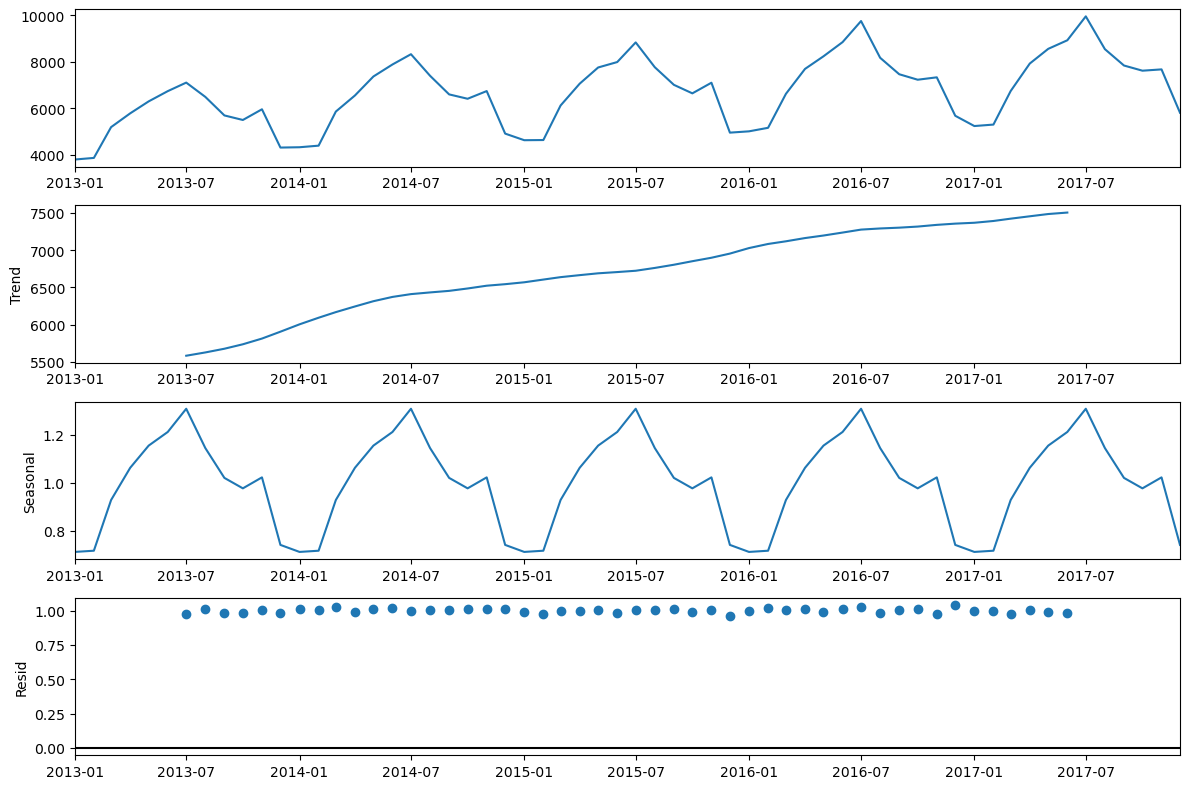

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts = data
result = seasonal_decompose(ts, model='multiplicative')
plt.rcParams['figure.figsize'] = [12, 8]

# 명확하게 추세나 계절성이 보인다
result.plot()
plt.show()

In [79]:
training = data[:"2016-12-01"]
test = data.drop(training.index)

In [80]:
# p value가 0.05가 넘기 때문에 정상성을 갖지 않는다고 할 수 있다
adf = adfuller(training, regression='ct')
print('ADF Statistic: {}'.format(adf[0]))
print('p-value : {}'.format(adf[1]))

ADF Statistic: -1.9997199341328131
p-value : 0.6015863303793997


<Axes: xlabel='day'>

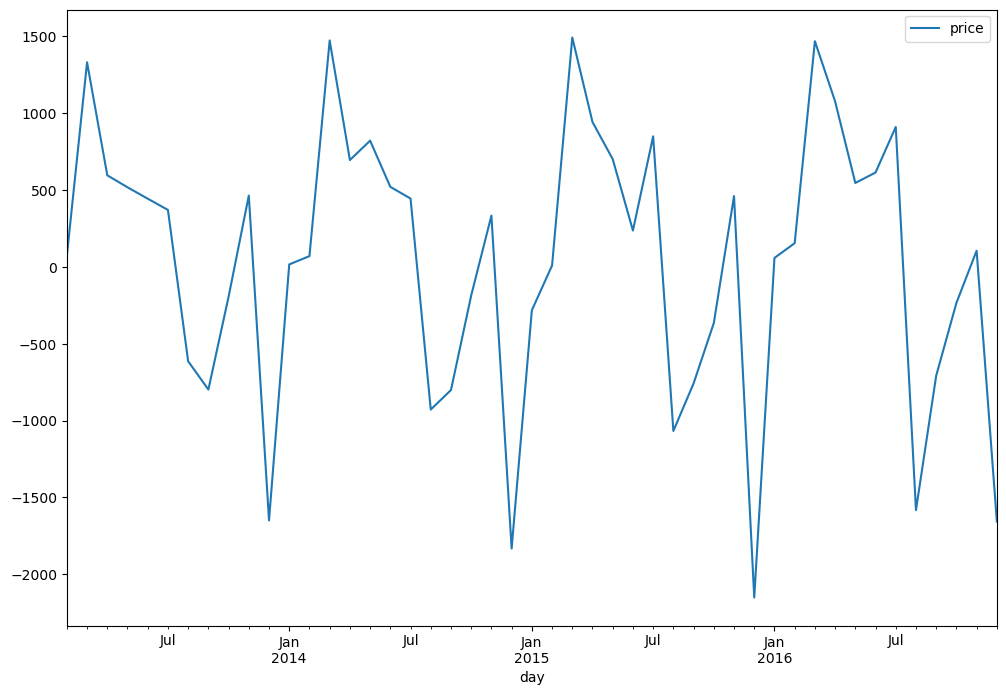

In [81]:
diff_data = training.diff(1)
diff_data = diff_data.dropna()
diff_data.plot()

In [82]:
# 추세가 보이지 않는다면 c를 사용한다. p val이 0.05 미만이다
adf = adfuller(diff_data, regression='c')
print('ADF Statistic: {}'.format(adf[0]))
print('p-value : {}'.format(adf[1]))

ADF Statistic: -12.094547576926411
p-value : 2.0851606399612174e-22


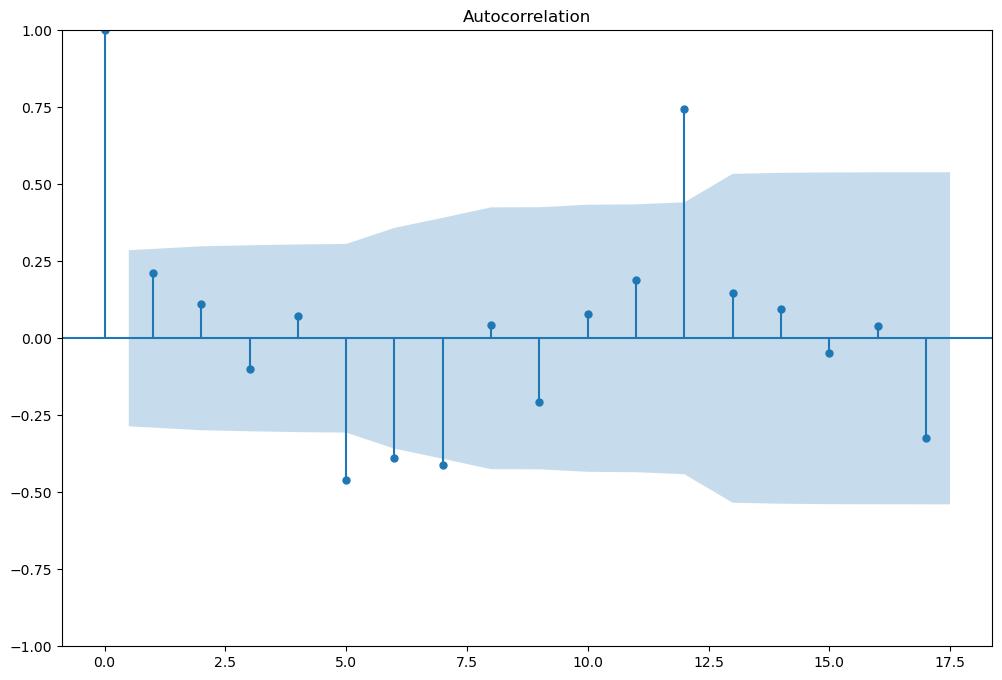

In [83]:
# 시차 2 이후에 0으로 수렴. AR모형에서 최적의 p값은 2
plot_acf(diff_data)
plt.show()

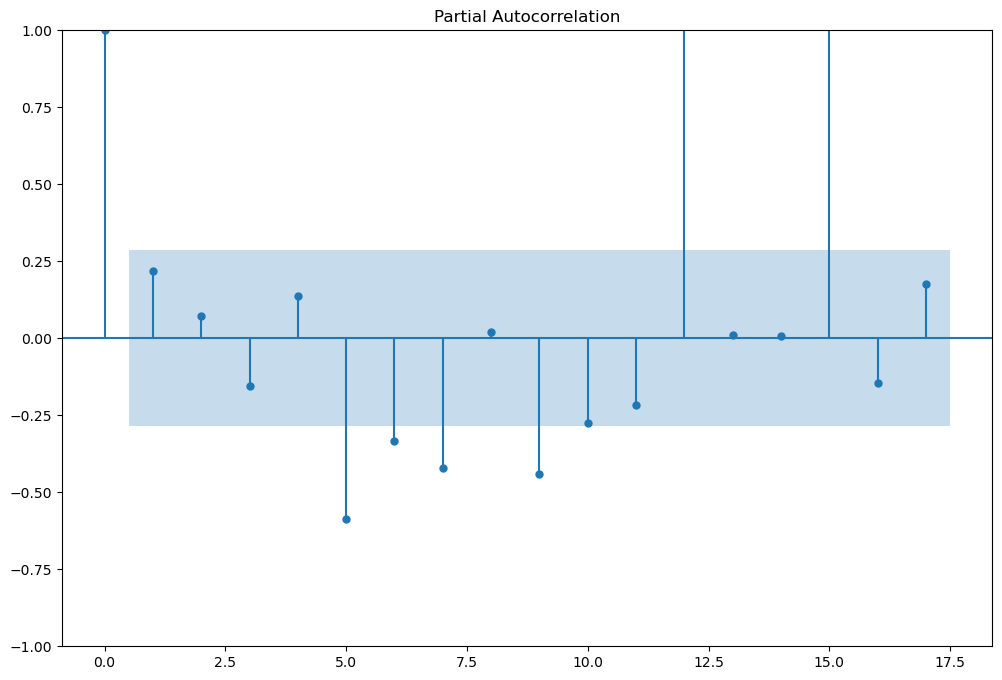

In [84]:
# 시차 2 이후에 0으로 수렴. MA모형에서 최적의 p값은 2
plot_pacf(diff_data)
plt.show()

In [85]:
model = ARIMA(training, order=(3,0,3), trend='ct')
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                   48
Model:                 ARIMA(3, 0, 3)   Log Likelihood                -371.447
Date:                Fri, 03 Nov 2023   AIC                            760.894
Time:                        22:06:16   BIC                            777.735
Sample:                    01-01-2013   HQIC                           767.258
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5283.2411    244.732     21.588      0.000    4803.576    5762.906
x1            48.8021      8.902      5.482      0.000      31.355      66.249
ar.L1          0.7320      0.029     25.305      0.000       0.675       0.789
ar.L2          0.7343      0.024     30.119      0.000       0.687       0.782
ar.L3         -0.9976      0.015    -65.927      0.000      -1.027      -0.968
ma.L1         -0.6945      0.711     -0.977      0.328      -2.088       0.699
ma.L2         -0.7832      0.810     -0.966      0.334      -2.372       0.805
ma.L3          0.9063      0.453      1.999      0.046       0.018       1.795
sigma2      4.257e+05      0.000   8.73e+08      0.000    4.26e+05    4.26e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.09   Jarque-Bera (JB):                 2.17
Prob(Q):                              0.30   Prob(JB):                         0.34
Heteroskedasticity (H):               1.49   Skew:                             0.50
Prob(H) (two-sided):                  0.43   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.25e+26. Standard errors may be unstable.
"""

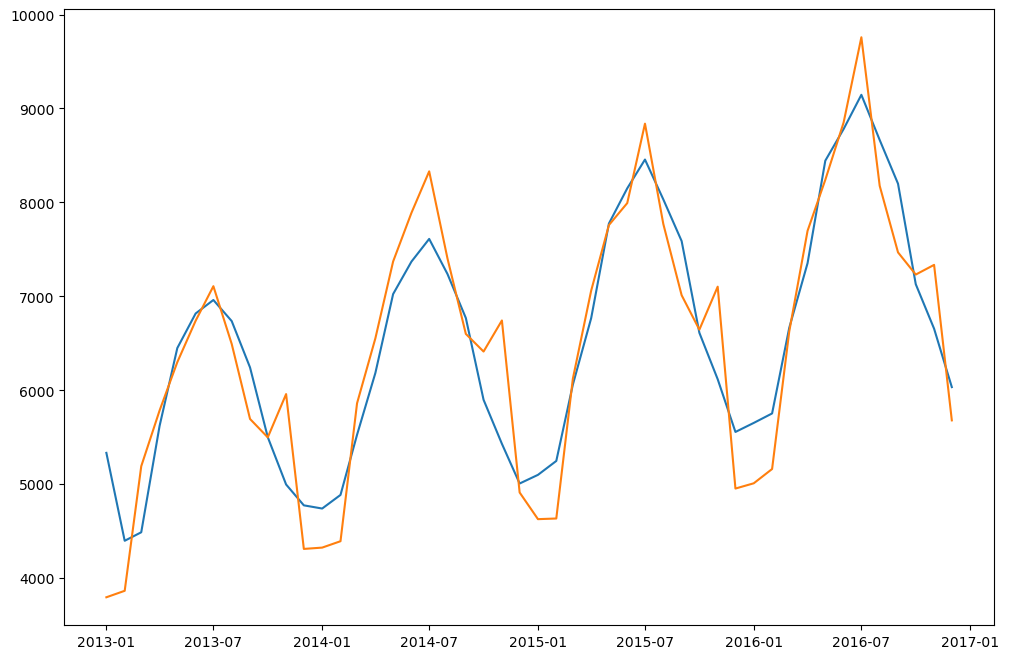

In [86]:
plt.plot(res.predict())
plt.plot(training)

In [89]:
forecast_data = res.forecast(steps=len(test), alpha=0.05)
pred_y = forecast_data
test_y = test

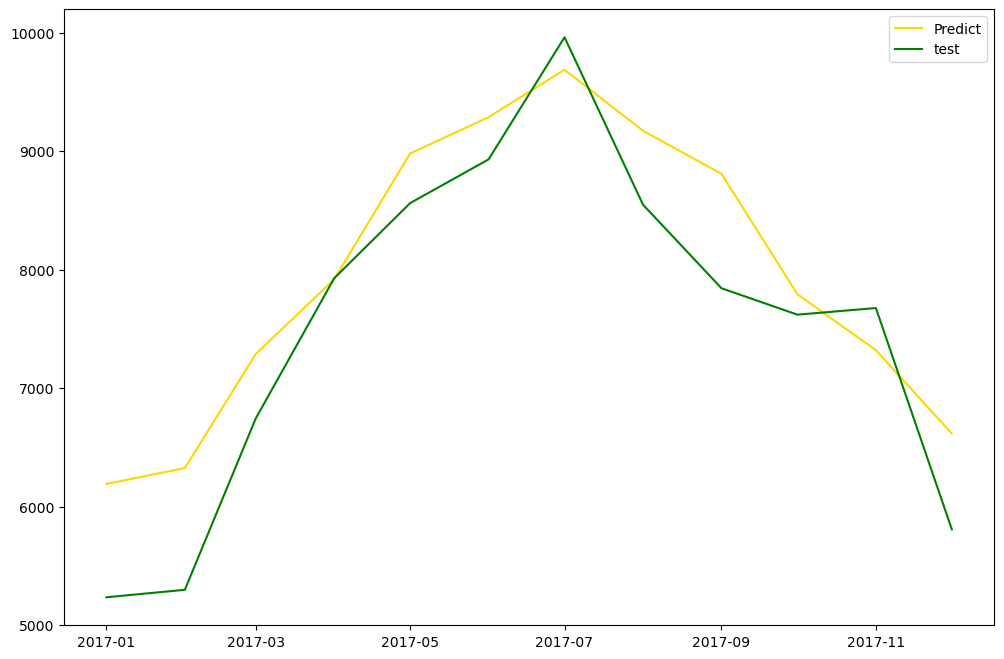

In [90]:
plt.plot(pred_y, color='gold', label='Predict')
plt.plot(test_y, color='green', label='test')
plt.legend()
plt.show()

In [91]:
print('r2 = ', r2_score(pred_y, test_y))
print('MSE = ', mean_squared_error(pred_y, test_y))

r2 =  0.7100199042035107
MSE =  397566.55987352156


In [92]:
auto_model = auto_arima(training, start_p = 0, d=1, start_q=0, max_p=3, max_q=3, start_P=0, start_Q=0,
                       max_P=3, max_Q=3, m=12, seasonal=True, information_criterion='aic', trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=481.846, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=482.652, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=482.466, Time=0.07 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=483.637, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=483.669, Time=0.03 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=481.031, Time=0.03 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=482.740, Time=0.08 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=482.616, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=482.682, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=480.687, Time=0.03 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=482.403, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=48

In [93]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -238.344
Date:                             Fri, 03 Nov 2023   AIC                            480.687
Time:                                     22:06:29   BIC                            483.798
Sample:                                 01-01-2013   HQIC                           481.761
                                      - 12-01-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3185      0.177     -1.801      0.072      -0.665       0.028
sigma2      4.803e+04   1.64e+04      2.924      0.003    1.58e+04    8.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.15
Prob(Q):                              0.95   Prob(JB):                         0.56
Heteroskedasticity (H):               1.56   Skew:                            -0.14
Prob(H) (two-sided):                  0.45   Kurtosis:                         2.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [94]:
auto_pred_y = pd.DataFrame(auto_model.predict(n_periods=len(test)), index=test.index)
auto_pred_y.columns = ['predicted_price']
auto_pred_y

,predicted_price
day,
2017-01-01,5609.436977
2017-02-01,5761.436977
2017-03-01,7225.436977
2017-04-01,8298.436977
2017-05-01,8841.436977
2017-06-01,9452.436977
2017-07-01,10359.436977
2017-08-01,8777.436977
2017-09-01,8068.436977


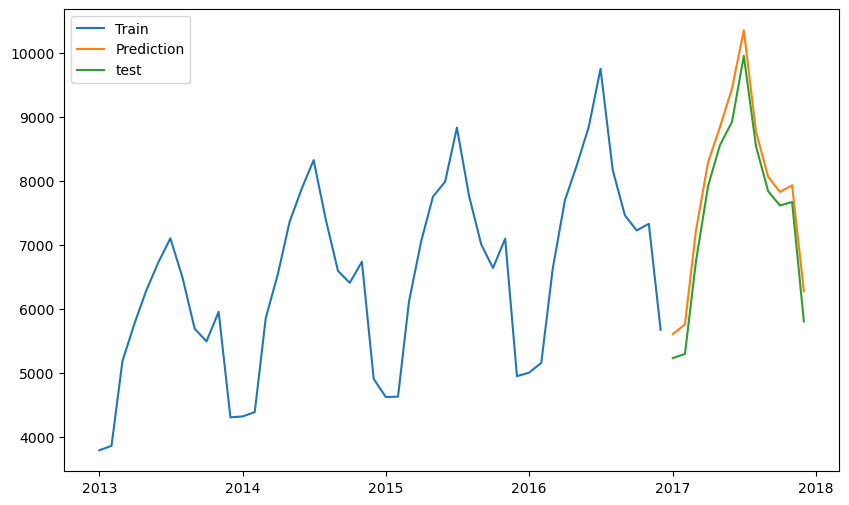

In [95]:
plt.figure(figsize=(10,6))
plt.plot(training, label='Train')
plt.plot(auto_pred_y, label='Prediction')
plt.plot(test, label='test')
plt.legend()
plt.show()

In [96]:
print('r2 = ', r2_score(test_y, auto_pred_y))
print('RMSE = ', np.sqrt(mean_squared_error(test_y, auto_pred_y)))

r2 =  0.9305467067712374
RMSE =  373.2064258949965


In [97]:
test_y

,price
day,
2017-01-01,5236
2017-02-01,5299
2017-03-01,6744
2017-04-01,7927
2017-05-01,8561
2017-06-01,8930
2017-07-01,9960
2017-08-01,8548
2017-09-01,7843


In [98]:
my_pro_test = test_y.reset_index()
my_pro_test.columns = ['ds', 'y']
my_pro_test

,ds,y
0,2017-01-01,5236
1,2017-02-01,5299
2,2017-03-01,6744
3,2017-04-01,7927
4,2017-05-01,8561
5,2017-06-01,8930
6,2017-07-01,9960
7,2017-08-01,8548
8,2017-09-01,7843
9,2017-10-01,7620


In [99]:
my_pro = training.reset_index()
my_pro.columns = ['ds', 'y']
my_pro.tail()

,ds,y
43,2016-08-01,8176
44,2016-09-01,7467
45,2016-10-01,7231
46,2016-11-01,7334
47,2016-12-01,5678


In [100]:
my_pro_con = pd.concat([my_pro, my_pro_test]).reset_index(drop=True)

In [101]:
m = Prophet()

In [102]:
m.fit(my_pro)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [103]:
my_pro_test

,ds,y
0,2017-01-01,5236
1,2017-02-01,5299
2,2017-03-01,6744
3,2017-04-01,7927
4,2017-05-01,8561
5,2017-06-01,8930
6,2017-07-01,9960
7,2017-08-01,8548
8,2017-09-01,7843
9,2017-10-01,7620


In [104]:
help(m.make_future_dataframe)

Help on method make_future_dataframe in module prophet.forecaster:

make_future_dataframe(periods, freq='D', include_history=True) method of prophet.forecaster.Prophet instance
    Simulate the trend using the extrapolated generative model.
    
    Parameters
    ----------
    periods: Int number of periods to forecast forward.
    freq: Any valid frequency for pd.date_range, such as 'D' or 'M'.
    include_history: Boolean to include the historical dates in the data
        frame for predictions.
    
    Returns
    -------
    pd.Dataframe that extends forward from the end of self.history for the
    requested number of periods.



In [105]:
future = m.make_future_dataframe(12, freq='MS')

In [106]:
forecast = m.predict(future)

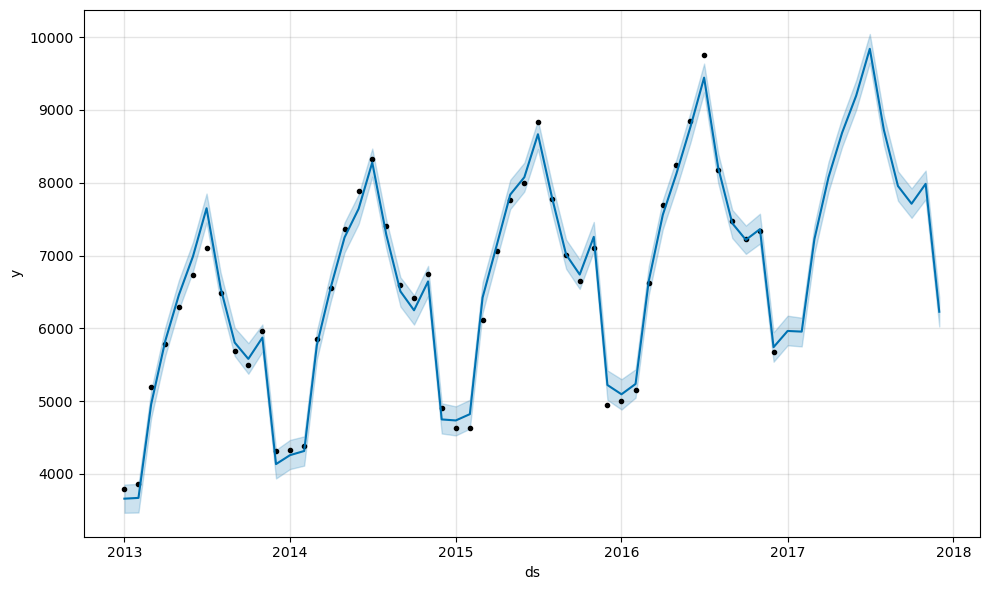

In [107]:
fig = m.plot(forecast)

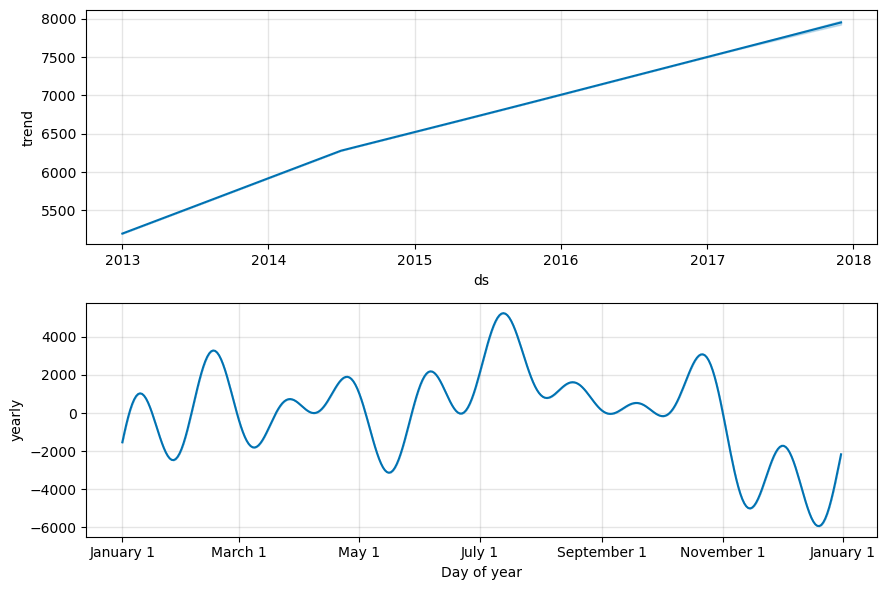

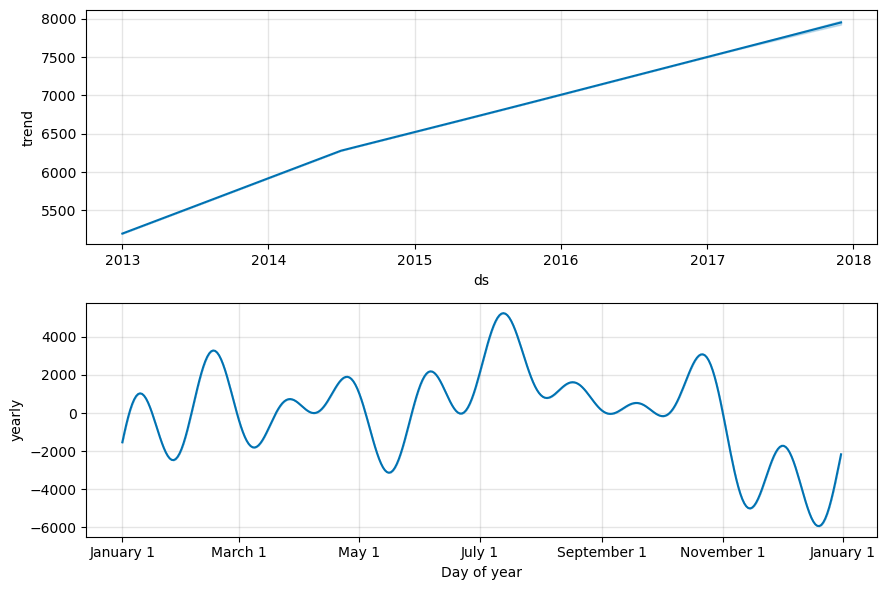

In [108]:
m.plot_components(forecast)

In [109]:
r2_score(forecast.loc[forecast.ds >= '2017-01-01'].yhat, my_pro_test.y)

0.9063240244412335

In [110]:
np.sqrt(mean_squared_error(forecast.loc[forecast.ds >= '2017-01-01'].yhat, my_pro_test.y))

369.1114803473123

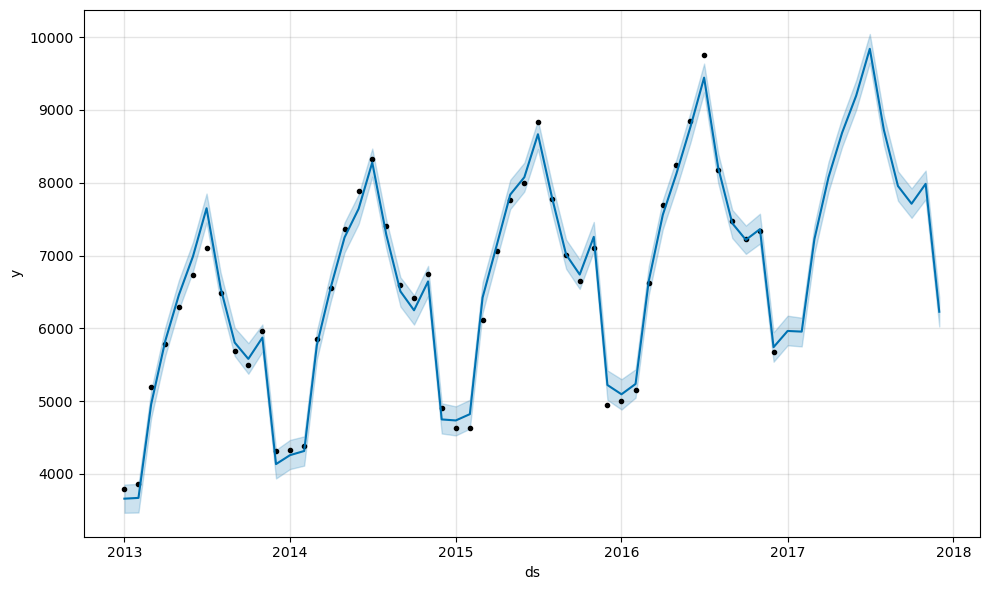

In [111]:
m.plot(forecast)
# plt.plot(my_pro_test.set_index('ds'), c='r')
plt.show()

## Exponential Smoothing: 
- This model uses weighted averages of past observations to make predictions about future values. There are several variations of this model, including simple exponential smoothing, Holt's linear exponential smoothing, and Holt-Winters' seasonal exponential smoothing.

## Neural Networks: 
- This model uses artificial neural networks to model complex relationships in the data. Neural networks can be used to make forecasts and to identify patterns and trends in the data.

## Vector Autoregression (VAR): 
- This model is used to model multiple time series variables that are interrelated. VAR models can be used to make forecasts and to analyze the relationships between different variables over time.

In [1187]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

In [1188]:
data = sm.datasets.macrodata.load_pandas().data
data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [1189]:
mydata = data[["realgdp", 'realdpi']]
mydata.index = data["year"]
mydata.head()

,realgdp,realdpi
year,,
1959.0,2710.349,1886.9
1959.0,2778.801,1919.7
1959.0,2775.488,1916.4
1959.0,2785.204,1931.3
1960.0,2847.699,1955.5


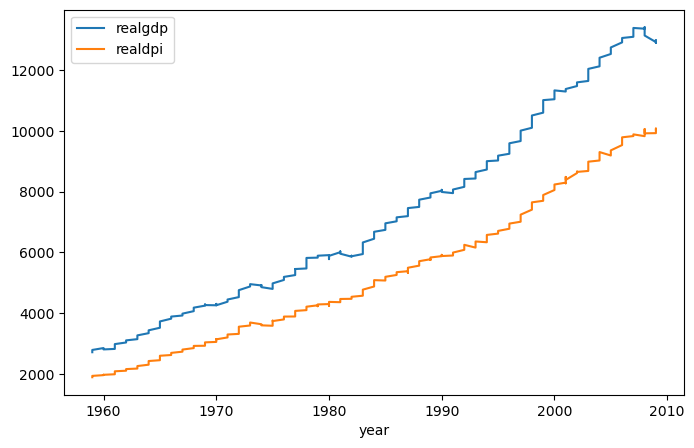

In [1191]:
mydata.plot(figsize = (8,5))
plt.show()

In [1194]:
adfuller_test = adfuller(mydata['realgdp'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

adfuller_test = adfuller(mydata['realdpi'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: 1.7504627967647166
p-value: 0.9982455372335032
ADF test statistic: 2.986025351954689
p-value: 1.0


In [1195]:
mydata_diff = mydata.diff().dropna()

In [1196]:
adfuller_test = adfuller(mydata_diff['realgdp'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

adfuller_test = adfuller(mydata_diff['realdpi'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -6.305695561658104
p-value: 3.327882187668259e-08
ADF test statistic: -8.86489334067301
p-value: 1.4493606159107938e-14


In [1197]:
train = mydata_diff.iloc[:-10,:]
test = mydata_diff.iloc[-10:,:]

In [1207]:
forecasting_model = VAR(train)
results_aic = []
for p in range(1,10):
    results = forecasting_model.fit(p) # p는 몇시점 이전 데이터에 대한 설정
    results_aic.append(results.aic)

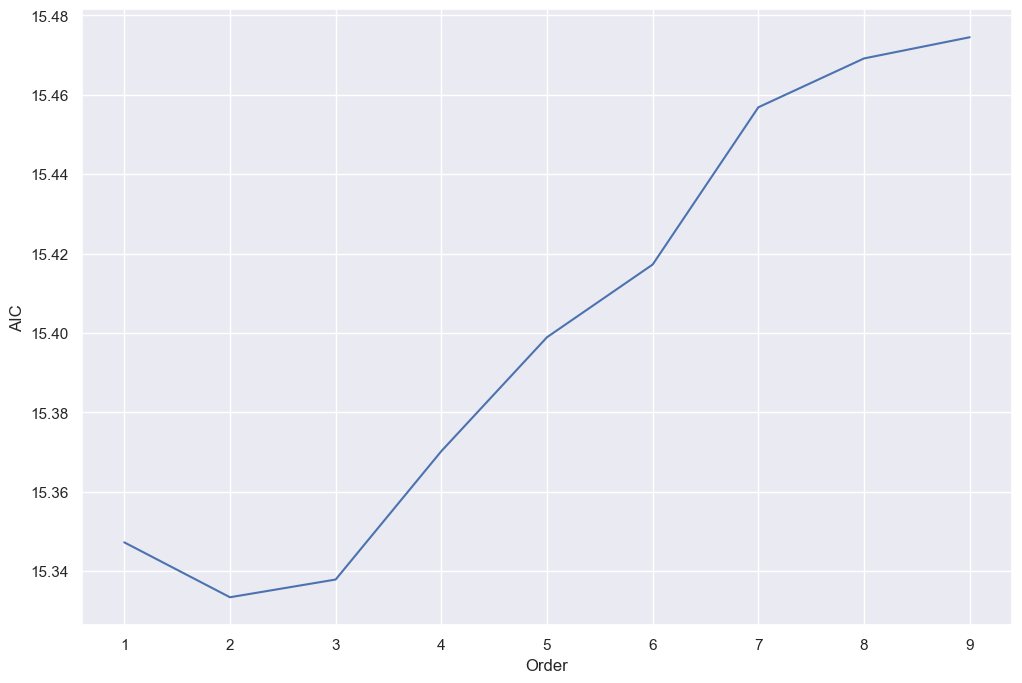

In [1328]:
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [1210]:
results = forecasting_model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 09, Mar, 2023
Time:                     07:52:23
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    15.5043
Nobs:                     190.000    HQIC:                   15.4026
Log likelihood:          -1985.87    FPE:                4.56270e+06
AIC:                      15.3334    Det(Omega_mle):     4.33171e+06
--------------------------------------------------------------------
Results for equation realgdp
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             23.807343         6.111430            3.896           0.000
L1.realgdp         0.176227         0.078131            2.256           0.024
L1.realdpi         0.213713         0.085309            2.505         

In [1329]:
laaged_values = train.values[-2:] # 위에서 도출한 것처럼 VAR모델을 맞추는데 최적의 순서로 2를 사용. 학습된 모델에 2일 동안의 훈련을 넣어 향후 10일 동안의 테스트 데이터를 예측
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=10), index = test.index, columns= ['realgdp_1d', 'realdpi_1d'])
forecast

,realgdp_1d,realdpi_1d
year,,
2007.0,61.872982,47.739232
2007.0,53.948996,41.742951
2007.0,56.171082,42.552316
2008.0,54.953081,42.023999
2008.0,55.109616,42.001007
2008.0,54.865410,41.937065
2008.0,54.841362,41.893996
2009.0,54.775171,41.878378
2009.0,54.754309,41.859837


In [1330]:
mydata["realgdp"].iloc[-10-1] 

13099.901

In [1331]:
# 차분한 데이터를 원래 값으로 
forecast["realgdp_forecasted"] = mydata["realgdp"].iloc[-10-1] + forecast['realgdp_1d'].cumsum()
forecast["realdpi_forecasted"] = mydata["realdpi"].iloc[-10-1] + forecast['realdpi_1d'].cumsum() 
forecast

,realgdp_1d,realdpi_1d,realgdp_forecasted,realdpi_forecasted
year,,,,
2007.0,61.872982,47.739232,13161.773982,9877.939232
2007.0,53.948996,41.742951,13215.722978,9919.682183
2007.0,56.171082,42.552316,13271.894060,9962.234500
2008.0,54.953081,42.023999,13326.847141,10004.258499
2008.0,55.109616,42.001007,13381.956757,10046.259506
2008.0,54.865410,41.937065,13436.822166,10088.196571
2008.0,54.841362,41.893996,13491.663528,10130.090566
2009.0,54.775171,41.878378,13546.438699,10171.968945
2009.0,54.754309,41.859837,13601.193008,10213.828781


<Axes: xlabel='year'>

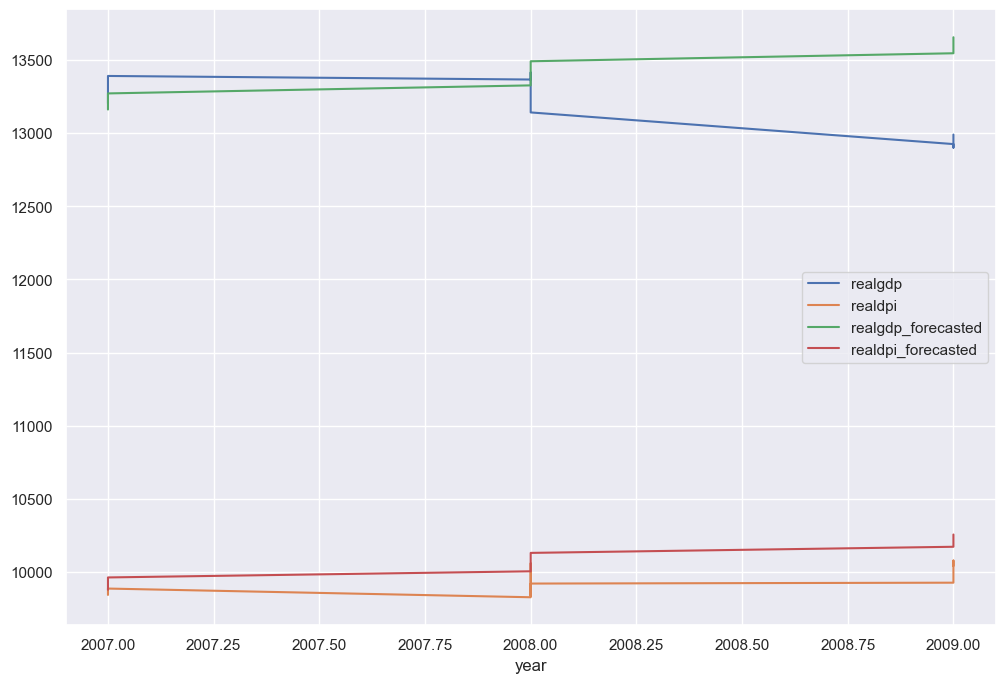

In [1332]:
test = mydata.iloc[-10:,:]
test["realgdp_forecasted"] = forecast["realgdp_forecasted"]
test["realdpi_forecasted"] = forecast["realdpi_forecasted"]
test.plot()